## 1. Libraries 📖

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import json 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn import metrics

import matplotlib.pyplot as plt

np.random.seed(1234)

## 2. Metrics 📏

In [2]:
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

## 3. Load data 📊

In [3]:
df_train = pd.read_csv("../../data/train/caco/caco_klek_train.csv")
df_test = pd.read_csv("../../data/train/caco/caco_klek_test.csv")
df_valid = pd.read_csv("../../data/train/caco/caco_klek_valid.csv")

df_train_all = pd.concat([df_train, df_valid])

In [4]:
X_train_all = df_train_all.loc[:, df_train_all.columns != 'permeability']
y_train_all = df_train_all['permeability']

X_train = df_train.loc[:, df_train.columns != 'permeability']
y_train = df_train['permeability']

X_test = df_test.loc[:, df_test.columns != 'permeability']
y_test = df_test['permeability']

X_valid = df_valid.loc[:, df_valid.columns != 'permeability']
y_valid = df_valid['permeability']

In [6]:
with open('../../klek_idxs.txt', 'r') as f:
    idxs = json.load(f) 
X_train_all = X_train_all[idxs['caco']]
X_train = X_train[idxs['caco']]
X_test = X_test[idxs['caco']]
X_valid = X_valid[idxs['caco']]

In [7]:
X_train.shape

(2460, 703)

In [8]:
X_test.shape

(704, 703)

In [9]:
X_valid.shape

(351, 703)

# 4. Model ⚙️

![FCNN](images/fcnn.png)

In [10]:
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.linear1 = nn.Linear(703, 300)
        self.linear2 = nn.Linear(300, 500)
        self.linear3 = nn.Linear(500, 600)
        self.linear4 = nn.Linear(600, 400)
        self.linear5 = nn.Linear(400, 50)
        self.linear6 = nn.Linear(50, 1)
        self.dropout = torch.nn.Dropout(0.5)
        self.batch = torch.nn.BatchNorm1d(500)
        self.batch2 = torch.nn.BatchNorm1d(600)
        
    def forward(self, x):
        y_pred = F.relu(self.linear1(x))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch(self.linear2(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch2(self.linear3(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.linear4(y_pred))
        y_pred = F.relu(self.linear5(y_pred))
        y_pred = self.dropout(y_pred)
        y_pred = self.linear6(y_pred)
        return y_pred

## 4.1. Grid search 🔎

In [11]:
lrs = [0.001, 0.005, 0.01, 0.05]
batch_sizes = [32, 64, 128, 256]

In [12]:
best_value = 1000
best_params = {'lr': None, 'batch_size': None, 'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
train_losses_all = []
test_losses_all = []
train_accs_all = []
test_accs_all = []

for lr in lrs:
    for batch_size in batch_sizes:
        
        model = FCNN()
        model.cuda()
        
        train_dataset = TensorDataset(torch.FloatTensor(X_train.values), torch.FloatTensor(y_train.values.reshape(-1, 1)))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

        valid_dataset = TensorDataset(torch.FloatTensor(X_valid.values), torch.FloatTensor(y_valid.values.reshape(-1, 1)))
        valid_loader = DataLoader(valid_dataset, batch_size=351, shuffle=False)

        epochs = 300
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr)

        train_losses = []
        test_losses = []
        train_accs = []
        test_accs = []
        
        print('Model: lr {}, batch_size {}'.format(lr, batch_size))

        for epoch in range(1, epochs + 1):

            print('################## EPOCH {} ##################'.format(epoch))

            model.train()
            train_correct = 0
            train_loss = 0


            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.cuda(), target.cuda()
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())

            train_loss /= len(train_loader)
            train_losses.append(train_loss)
            train_acc = train_correct/len(train_loader)
            train_accs.append(train_acc)
            print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))

            model.eval()

            test_loss = 0
            test_correct = 0

            with torch.no_grad():
                for data, target in valid_loader:
                    data, target = data.cuda(), target.cuda()
                    output = model(data)
                    test_loss += criterion(output, target).item()
                    test_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())

            test_loss /= len(valid_loader)
            test_losses.append(test_loss)
            test_acc =test_correct/len(valid_loader)
            test_accs.append(test_acc)

            if test_loss<best_value:
                best_value = test_loss
                best_params['lr'] = lr
                best_params['batch_size'] = batch_size
                best_params['epoch'] = epoch
                best_params['train_loss'] = train_loss
                best_params['test_loss'] = test_loss
                best_params['train_acc'] = train_acc
                best_params['test_acc'] = test_acc 
            print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

        train_losses_all.append(train_losses)
        test_losses_all.append(test_losses)
        train_accs_all.append(train_accs)
        test_accs_all.append(test_accs)

print(best_params)

Model: lr 0.001, batch_size 32
################## EPOCH 1 ##################
Train Avg. loss: 820.5423316460151, Accuracy: -0.1322516968294586
Test Avg. loss: 703.87060546875, Accuracy: 0.2385759498800719
################## EPOCH 2 ##################
Train Avg. loss: 712.4477513300908, Accuracy: -0.08689398081070956
Test Avg. loss: 573.9100341796875, Accuracy: 0.3791630590576426
################## EPOCH 3 ##################
Train Avg. loss: 629.0542103160511, Accuracy: -0.0715920560821517
Test Avg. loss: 515.4747314453125, Accuracy: 0.4423764245437981
################## EPOCH 4 ##################
Train Avg. loss: 563.6073259626116, Accuracy: -0.08301869364373736
Test Avg. loss: 491.605224609375, Accuracy: 0.46819771318620174
################## EPOCH 5 ##################
Train Avg. loss: 504.67349124264405, Accuracy: 0.017330719777418645
Test Avg. loss: 454.5775146484375, Accuracy: 0.5082530720825635
################## EPOCH 6 ##################
Train Avg. loss: 548.6988713648412, Accur

Train Avg. loss: 231.0875238195642, Accuracy: 0.49266164300093024
Test Avg. loss: 335.9734191894531, Accuracy: 0.6365550555584802
################## EPOCH 49 ##################
Train Avg. loss: 238.082123050442, Accuracy: 0.4158079273154394
Test Avg. loss: 395.7188720703125, Accuracy: 0.571924358310027
################## EPOCH 50 ##################
Train Avg. loss: 210.07529350379843, Accuracy: 0.5625073372918421
Test Avg. loss: 365.2053527832031, Accuracy: 0.6049329067941336
################## EPOCH 51 ##################
Train Avg. loss: 235.84244636436563, Accuracy: 0.5465417226605372
Test Avg. loss: 390.52667236328125, Accuracy: 0.5775411287708163
################## EPOCH 52 ##################
Train Avg. loss: 250.5679538280933, Accuracy: 0.5510559254585904
Test Avg. loss: 432.4930419921875, Accuracy: 0.5321432999654503
################## EPOCH 53 ##################
Train Avg. loss: 203.4694644878437, Accuracy: 0.5046498117738966
Test Avg. loss: 403.2264099121094, Accuracy: 0.563802

Train Avg. loss: 166.30464534016397, Accuracy: 0.6549442137526028
Test Avg. loss: 347.82623291015625, Accuracy: 0.6237330485068177
################## EPOCH 96 ##################
Train Avg. loss: 131.41130254175755, Accuracy: 0.6954023475090529
Test Avg. loss: 321.89312744140625, Accuracy: 0.6517866745711345
################## EPOCH 97 ##################
Train Avg. loss: 145.01580552930955, Accuracy: 0.6768823281767145
Test Avg. loss: 357.2919006347656, Accuracy: 0.6134934244955056
################## EPOCH 98 ##################
Train Avg. loss: 165.9959604337618, Accuracy: 0.6765841542983592
Test Avg. loss: 333.1139831542969, Accuracy: 0.6396482767244875
################## EPOCH 99 ##################
Train Avg. loss: 195.94350274816736, Accuracy: 0.6597542374381341
Test Avg. loss: 346.2971496582031, Accuracy: 0.6253871693835918
################## EPOCH 100 ##################
Train Avg. loss: 168.65932157442168, Accuracy: 0.6900050660562812
Test Avg. loss: 415.8456115722656, Accuracy: 0.

Train Avg. loss: 110.35528277112292, Accuracy: 0.7613739438547087
Test Avg. loss: 365.2327880859375, Accuracy: 0.6049032436244096
################## EPOCH 143 ##################
Train Avg. loss: 112.25287182300121, Accuracy: 0.7541863670302194
Test Avg. loss: 369.5757141113281, Accuracy: 0.6002051658711756
################## EPOCH 144 ##################
Train Avg. loss: 119.40309990226449, Accuracy: 0.7316299468221041
Test Avg. loss: 375.30194091796875, Accuracy: 0.5940107289505387
################## EPOCH 145 ##################
Train Avg. loss: 127.25229496150821, Accuracy: 0.7182247305097333
Test Avg. loss: 370.912109375, Accuracy: 0.5987595508151975
################## EPOCH 146 ##################
Train Avg. loss: 123.69241268603832, Accuracy: 0.7316371589386553
Test Avg. loss: 390.23760986328125, Accuracy: 0.5778538370167688
################## EPOCH 147 ##################
Train Avg. loss: 162.38944014016684, Accuracy: 0.7132518645171652
Test Avg. loss: 366.71038818359375, Accuracy: 

Train Avg. loss: 123.20470631587041, Accuracy: 0.743956996830531
Test Avg. loss: 371.4167175292969, Accuracy: 0.5982136847724496
################## EPOCH 190 ##################
Train Avg. loss: 154.12469918387276, Accuracy: 0.7459953396068817
Test Avg. loss: 399.5923767089844, Accuracy: 0.567734165515861
################## EPOCH 191 ##################
Train Avg. loss: 105.7574390312294, Accuracy: 0.768515734071685
Test Avg. loss: 354.77166748046875, Accuracy: 0.6162197136283949
################## EPOCH 192 ##################
Train Avg. loss: 107.71795560167982, Accuracy: 0.7861632803586789
Test Avg. loss: 396.84539794921875, Accuracy: 0.5707057319522607
################## EPOCH 193 ##################
Train Avg. loss: 108.26354011931977, Accuracy: 0.776983900340973
Test Avg. loss: 374.9578857421875, Accuracy: 0.594382928508044
################## EPOCH 194 ##################
Train Avg. loss: 110.57206681486848, Accuracy: 0.773844712345416
Test Avg. loss: 370.3876953125, Accuracy: 0.59932

Train Avg. loss: 158.4440736151361, Accuracy: 0.7716434597203732
Test Avg. loss: 362.58721923828125, Accuracy: 0.607765155632815
################## EPOCH 237 ##################
Train Avg. loss: 104.9320331920277, Accuracy: 0.7731610344477634
Test Avg. loss: 362.9222412109375, Accuracy: 0.6074027115578466
################## EPOCH 238 ##################
Train Avg. loss: 117.74525355054186, Accuracy: 0.7668739046302162
Test Avg. loss: 380.0936279296875, Accuracy: 0.5888272933055145
################## EPOCH 239 ##################
Train Avg. loss: 105.10211369898413, Accuracy: 0.8012012126927925
Test Avg. loss: 357.63140869140625, Accuracy: 0.6131261618763701
################## EPOCH 240 ##################
Train Avg. loss: 126.03262383597237, Accuracy: 0.7582390732534595
Test Avg. loss: 399.8833312988281, Accuracy: 0.5674194573346771
################## EPOCH 241 ##################
Train Avg. loss: 124.8289183579482, Accuracy: 0.7815462733314915
Test Avg. loss: 394.09356689453125, Accuracy: 

Train Avg. loss: 94.38202340262276, Accuracy: 0.8032009084697771
Test Avg. loss: 332.611572265625, Accuracy: 0.6401917744869213
################## EPOCH 284 ##################
Train Avg. loss: 103.90259306771415, Accuracy: 0.8163950224972525
Test Avg. loss: 370.71356201171875, Accuracy: 0.5989743105357259
################## EPOCH 285 ##################
Train Avg. loss: 89.84706128108037, Accuracy: 0.8050465044378238
Test Avg. loss: 346.72076416015625, Accuracy: 0.6249289208414149
################## EPOCH 286 ##################
Train Avg. loss: 105.78932826549976, Accuracy: 0.7970460665899285
Test Avg. loss: 357.3964538574219, Accuracy: 0.6133803385525571
################## EPOCH 287 ##################
Train Avg. loss: 96.62415281518713, Accuracy: 0.805971377788415
Test Avg. loss: 342.8268737792969, Accuracy: 0.6291412079785508
################## EPOCH 288 ##################
Train Avg. loss: 97.58620125906808, Accuracy: 0.8176614270349885
Test Avg. loss: 393.8319091796875, Accuracy: 0.5

Train Avg. loss: 301.4591886080228, Accuracy: 0.48477610461644827
Test Avg. loss: 412.2181396484375, Accuracy: 0.5540760284010304
################## EPOCH 31 ##################
Train Avg. loss: 281.182735149677, Accuracy: 0.5441407715611913
Test Avg. loss: 351.817138671875, Accuracy: 0.6194158580310006
################## EPOCH 32 ##################
Train Avg. loss: 260.6910166618151, Accuracy: 0.5811445866551506
Test Avg. loss: 386.179931640625, Accuracy: 0.5822432964884777
################## EPOCH 33 ##################
Train Avg. loss: 310.346181624975, Accuracy: 0.4755414009152622
Test Avg. loss: 334.75701904296875, Accuracy: 0.6378709319706781
################## EPOCH 34 ##################
Train Avg. loss: 298.63462252494617, Accuracy: 0.5585444740064024
Test Avg. loss: 401.8970031738281, Accuracy: 0.5652410894817005
################## EPOCH 35 ##################
Train Avg. loss: 299.0292773124499, Accuracy: 0.5550918547302315
Test Avg. loss: 368.72869873046875, Accuracy: 0.60112146

Train Avg. loss: 218.15286294007913, Accuracy: 0.6429820463102867
Test Avg. loss: 343.64959716796875, Accuracy: 0.6282512111362468
################## EPOCH 78 ##################
Train Avg. loss: 195.53233083089194, Accuracy: 0.6779145643181091
Test Avg. loss: 394.3903503417969, Accuracy: 0.5733615362797461
################## EPOCH 79 ##################
Train Avg. loss: 227.8659768715883, Accuracy: 0.6608174300865474
Test Avg. loss: 409.49737548828125, Accuracy: 0.5570192633697297
################## EPOCH 80 ##################
Train Avg. loss: 182.01519051576273, Accuracy: 0.6706008891265914
Test Avg. loss: 389.7035827636719, Accuracy: 0.578431535612612
################## EPOCH 81 ##################
Train Avg. loss: 223.63595933180588, Accuracy: 0.6798614028900393
Test Avg. loss: 364.73846435546875, Accuracy: 0.6054379884282977
################## EPOCH 82 ##################
Train Avg. loss: 203.2923310108674, Accuracy: 0.6717071322605969
Test Avg. loss: 378.83551025390625, Accuracy: 0.5

Train Avg. loss: 178.7814290217864, Accuracy: 0.7265813146399285
Test Avg. loss: 400.731201171875, Accuracy: 0.5665022049914966
################## EPOCH 125 ##################
Train Avg. loss: 182.0764298072228, Accuracy: 0.7286909732469915
Test Avg. loss: 394.1045227050781, Accuracy: 0.5736707265935723
################## EPOCH 126 ##################
Train Avg. loss: 186.92434702164087, Accuracy: 0.6897366755130562
Test Avg. loss: 403.0325927734375, Accuracy: 0.5640126253955315
################## EPOCH 127 ##################
Train Avg. loss: 155.4300596775153, Accuracy: 0.7418801792259762
Test Avg. loss: 341.1660461425781, Accuracy: 0.6309378175406649
################## EPOCH 128 ##################
Train Avg. loss: 177.26204290145483, Accuracy: 0.6913094311389167
Test Avg. loss: 355.190673828125, Accuracy: 0.6157664627710776
################## EPOCH 129 ##################
Train Avg. loss: 190.64135204217374, Accuracy: 0.732883713274175
Test Avg. loss: 388.8966369628906, Accuracy: 0.579

Train Avg. loss: 155.33264032999674, Accuracy: 0.7624331272215008
Test Avg. loss: 375.55047607421875, Accuracy: 0.5937418747058704
################## EPOCH 172 ##################
Train Avg. loss: 137.40544930482523, Accuracy: 0.7824595061044811
Test Avg. loss: 399.2074279785156, Accuracy: 0.5681505614239645
################## EPOCH 173 ##################
Train Avg. loss: 151.24327742747772, Accuracy: 0.7749736842483365
Test Avg. loss: 434.2221374511719, Accuracy: 0.5302728101849361
################## EPOCH 174 ##################
Train Avg. loss: 159.3060158949632, Accuracy: 0.7587971213703367
Test Avg. loss: 402.4577941894531, Accuracy: 0.5646344378347297
################## EPOCH 175 ##################
Train Avg. loss: 164.61671995505307, Accuracy: 0.7657427420578016
Test Avg. loss: 433.2790222167969, Accuracy: 0.5312930813015193
################## EPOCH 176 ##################
Train Avg. loss: 131.33904721186713, Accuracy: 0.7696778905749202
Test Avg. loss: 409.28704833984375, Accuracy

Train Avg. loss: 140.34713177803235, Accuracy: 0.7875849133649765
Test Avg. loss: 437.8450012207031, Accuracy: 0.5263537438385224
################## EPOCH 219 ##################
Train Avg. loss: 141.3997753828, Accuracy: 0.8048125676933607
Test Avg. loss: 460.1966247558594, Accuracy: 0.5021744834399997
################## EPOCH 220 ##################
Train Avg. loss: 158.2711478991386, Accuracy: 0.7872678657266857
Test Avg. loss: 483.90460205078125, Accuracy: 0.47652797881537134
################## EPOCH 221 ##################
Train Avg. loss: 161.36250412769806, Accuracy: 0.7816416780246751
Test Avg. loss: 424.0679626464844, Accuracy: 0.5412572622391532
################## EPOCH 222 ##################
Train Avg. loss: 135.44007399143317, Accuracy: 0.7980158070886259
Test Avg. loss: 403.63092041015625, Accuracy: 0.5633653886009148
################## EPOCH 223 ##################
Train Avg. loss: 151.11335020798904, Accuracy: 0.7813527962277909
Test Avg. loss: 395.5520935058594, Accuracy: 0

Train Avg. loss: 129.09204913408328, Accuracy: 0.8061115968386802
Test Avg. loss: 401.9823303222656, Accuracy: 0.565148771644524
################## EPOCH 266 ##################
Train Avg. loss: 162.72453831403683, Accuracy: 0.7562948305449293
Test Avg. loss: 441.4267272949219, Accuracy: 0.5224791540830567
################## EPOCH 267 ##################
Train Avg. loss: 127.31076441055689, Accuracy: 0.8008155726746086
Test Avg. loss: 425.6691589355469, Accuracy: 0.5395251629579526
################## EPOCH 268 ##################
Train Avg. loss: 137.71739133199057, Accuracy: 0.7991501348024438
Test Avg. loss: 403.1827392578125, Accuracy: 0.5638502477468663
################## EPOCH 269 ##################
Train Avg. loss: 136.8909456301958, Accuracy: 0.7969382158660065
Test Avg. loss: 433.6213073730469, Accuracy: 0.5309227944679493
################## EPOCH 270 ##################
Train Avg. loss: 136.5454984811636, Accuracy: 0.7955446962298508
Test Avg. loss: 413.5072021484375, Accuracy: 0.

Train Avg. loss: 355.91057415008544, Accuracy: 0.5348231158179905
Test Avg. loss: 350.8602600097656, Accuracy: 0.6204509533687959
################## EPOCH 13 ##################
Train Avg. loss: 329.9412727355957, Accuracy: 0.5875437477069391
Test Avg. loss: 383.1664733886719, Accuracy: 0.5855031691067916
################## EPOCH 14 ##################
Train Avg. loss: 343.82116775512696, Accuracy: 0.536815481944186
Test Avg. loss: 350.0010681152344, Accuracy: 0.6213803764926487
################## EPOCH 15 ##################
Train Avg. loss: 323.4709274291992, Accuracy: 0.5389037558557426
Test Avg. loss: 392.1170349121094, Accuracy: 0.5758207524961406
################## EPOCH 16 ##################
Train Avg. loss: 280.49594593048096, Accuracy: 0.6166574467276831
Test Avg. loss: 361.04486083984375, Accuracy: 0.6094335909477571
################## EPOCH 17 ##################
Train Avg. loss: 280.8888256072998, Accuracy: 0.6390690218754255
Test Avg. loss: 441.1966552734375, Accuracy: 0.52272

Train Avg. loss: 202.79715223312377, Accuracy: 0.719162903763918
Test Avg. loss: 405.1177978515625, Accuracy: 0.5617569485741674
################## EPOCH 61 ##################
Train Avg. loss: 185.82394714355468, Accuracy: 0.7512692211500442
Test Avg. loss: 417.9752502441406, Accuracy: 0.5478481629724471
################## EPOCH 62 ##################
Train Avg. loss: 179.21131324768066, Accuracy: 0.7353157764581942
Test Avg. loss: 381.8141784667969, Accuracy: 0.586966033481247
################## EPOCH 63 ##################
Train Avg. loss: 214.91374168395996, Accuracy: 0.7137039514981636
Test Avg. loss: 347.783935546875, Accuracy: 0.6237788145071628
################## EPOCH 64 ##################
Train Avg. loss: 178.13322944641112, Accuracy: 0.7425891699248853
Test Avg. loss: 369.7117614746094, Accuracy: 0.6000580013212963
################## EPOCH 65 ##################
Train Avg. loss: 188.1980152130127, Accuracy: 0.7503758880011617
Test Avg. loss: 365.37481689453125, Accuracy: 0.60474

Train Avg. loss: 164.48150234222413, Accuracy: 0.7745547201249763
Test Avg. loss: 371.4045104980469, Accuracy: 0.598226853059787
################## EPOCH 109 ##################
Train Avg. loss: 153.49762868881226, Accuracy: 0.7834689704503692
Test Avg. loss: 408.01068115234375, Accuracy: 0.5586275069800879
################## EPOCH 110 ##################
Train Avg. loss: 161.69425506591796, Accuracy: 0.7629163328028936
Test Avg. loss: 394.54241943359375, Accuracy: 0.573197028171899
################## EPOCH 111 ##################
Train Avg. loss: 140.04109954833984, Accuracy: 0.8050482532694421
Test Avg. loss: 361.5592041015625, Accuracy: 0.60887718183096
################## EPOCH 112 ##################
Train Avg. loss: 177.66299438476562, Accuracy: 0.783083483784101
Test Avg. loss: 407.24261474609375, Accuracy: 0.5594584127652673
################## EPOCH 113 ##################
Train Avg. loss: 172.47072238922118, Accuracy: 0.7653184345208277
Test Avg. loss: 411.169189453125, Accuracy: 0.

Train Avg. loss: 141.33506937026976, Accuracy: 0.7952918416551442
Test Avg. loss: 428.9030456542969, Accuracy: 0.5360268540657405
################## EPOCH 157 ##################
Train Avg. loss: 140.2603883743286, Accuracy: 0.796704684946734
Test Avg. loss: 363.0370788574219, Accuracy: 0.6072784601476903
################## EPOCH 158 ##################
Train Avg. loss: 148.26138005256652, Accuracy: 0.8061124586807402
Test Avg. loss: 360.6795349121094, Accuracy: 0.609828776765521
################## EPOCH 159 ##################
Train Avg. loss: 131.82457370758056, Accuracy: 0.8233662038102393
Test Avg. loss: 387.7627868652344, Accuracy: 0.5805310624403182
################## EPOCH 160 ##################
Train Avg. loss: 131.1840606689453, Accuracy: 0.8175714737377604
Test Avg. loss: 403.9267272949219, Accuracy: 0.5630454449588824
################## EPOCH 161 ##################
Train Avg. loss: 131.92115287780763, Accuracy: 0.8075105115761515
Test Avg. loss: 395.2041015625, Accuracy: 0.5724

Train Avg. loss: 125.40850629806519, Accuracy: 0.8260446485878458
Test Avg. loss: 396.05181884765625, Accuracy: 0.571564216578879
################## EPOCH 205 ##################
Train Avg. loss: 141.41567668914794, Accuracy: 0.8179836944418403
Test Avg. loss: 360.556396484375, Accuracy: 0.609961978223853
################## EPOCH 206 ##################
Train Avg. loss: 109.3692135810852, Accuracy: 0.8540680467503993
Test Avg. loss: 371.6006164550781, Accuracy: 0.5980147187678886
################## EPOCH 207 ##################
Train Avg. loss: 143.4051383972168, Accuracy: 0.8119982349645392
Test Avg. loss: 399.81475830078125, Accuracy: 0.5674935720918133
################## EPOCH 208 ##################
Train Avg. loss: 129.25400524139405, Accuracy: 0.8278804510630108
Test Avg. loss: 407.0217590332031, Accuracy: 0.5596972823920925
################## EPOCH 209 ##################
Train Avg. loss: 120.6453505039215, Accuracy: 0.8301854054128425
Test Avg. loss: 407.70233154296875, Accuracy: 0.

Train Avg. loss: 109.65918798446656, Accuracy: 0.8576772143937115
Test Avg. loss: 370.84271240234375, Accuracy: 0.5988345601397645
################## EPOCH 253 ##################
Train Avg. loss: 112.34443836212158, Accuracy: 0.8417767846694975
Test Avg. loss: 381.97418212890625, Accuracy: 0.5867929673851571
################## EPOCH 254 ##################
Train Avg. loss: 107.5333351135254, Accuracy: 0.8634642372643688
Test Avg. loss: 399.090087890625, Accuracy: 0.5682775037583896
################## EPOCH 255 ##################
Train Avg. loss: 121.63783588409424, Accuracy: 0.8435302386762891
Test Avg. loss: 431.7044982910156, Accuracy: 0.5329963699860867
################## EPOCH 256 ##################
Train Avg. loss: 115.22559604644775, Accuracy: 0.8446240257330242
Test Avg. loss: 461.5943298339844, Accuracy: 0.5006624751640956
################## EPOCH 257 ##################
Train Avg. loss: 143.12003269195557, Accuracy: 0.8161245992731253
Test Avg. loss: 428.1695556640625, Accuracy:

Train Avg. loss: 88.89947490692138, Accuracy: 0.8724432143240273
Test Avg. loss: 389.3616027832031, Accuracy: 0.5788014971302446
Model: lr 0.001, batch_size 256
################## EPOCH 1 ##################
Train Avg. loss: 1000.5897521972656, Accuracy: -0.20067427334890464
Test Avg. loss: 1079.57421875, Accuracy: -0.1678478068410285
################## EPOCH 2 ##################
Train Avg. loss: 782.222021484375, Accuracy: 0.07334394963607495
Test Avg. loss: 876.6137084960938, Accuracy: 0.05170816874185746
################## EPOCH 3 ##################
Train Avg. loss: 616.9490600585938, Accuracy: 0.269443936481475
Test Avg. loss: 756.8134155273438, Accuracy: 0.18130430175261592
################## EPOCH 4 ##################
Train Avg. loss: 502.65552673339846, Accuracy: 0.39127863735035284
Test Avg. loss: 537.4592895507812, Accuracy: 0.41859421862095647
################## EPOCH 5 ##################
Train Avg. loss: 432.6533447265625, Accuracy: 0.42856466102057034
Test Avg. loss: 457.213

Train Avg. loss: 235.54105529785156, Accuracy: 0.7235609239017984
Test Avg. loss: 412.62005615234375, Accuracy: 0.5536412272886704
################## EPOCH 49 ##################
Train Avg. loss: 245.44967880249024, Accuracy: 0.6957610009708693
Test Avg. loss: 439.97998046875, Accuracy: 0.5240441993022221
################## EPOCH 50 ##################
Train Avg. loss: 209.9700569152832, Accuracy: 0.7255986437857417
Test Avg. loss: 370.74871826171875, Accuracy: 0.5989362831411449
################## EPOCH 51 ##################
Train Avg. loss: 215.00771484375, Accuracy: 0.7365438892648196
Test Avg. loss: 338.88397216796875, Accuracy: 0.6334065099033455
################## EPOCH 52 ##################
Train Avg. loss: 269.1653656005859, Accuracy: 0.6416406098262233
Test Avg. loss: 373.89886474609375, Accuracy: 0.5955285235648113
################## EPOCH 53 ##################
Train Avg. loss: 254.07911834716796, Accuracy: 0.7010099451171805
Test Avg. loss: 390.9273986816406, Accuracy: 0.57710

Train Avg. loss: 173.0092575073242, Accuracy: 0.7776343081490636
Test Avg. loss: 366.60198974609375, Accuracy: 0.6034220831483115
################## EPOCH 97 ##################
Train Avg. loss: 178.00250625610352, Accuracy: 0.774545443252
Test Avg. loss: 369.4160461425781, Accuracy: 0.6003779278548841
################## EPOCH 98 ##################
Train Avg. loss: 184.6021598815918, Accuracy: 0.7573712246239171
Test Avg. loss: 381.8280334472656, Accuracy: 0.5869510079159015
################## EPOCH 99 ##################
Train Avg. loss: 168.8543258666992, Accuracy: 0.7718767094691057
Test Avg. loss: 380.7433776855469, Accuracy: 0.5881243751330678
################## EPOCH 100 ##################
Train Avg. loss: 163.78036193847657, Accuracy: 0.785268069540127
Test Avg. loss: 368.9894104003906, Accuracy: 0.6008394459120985
################## EPOCH 101 ##################
Train Avg. loss: 215.2362258911133, Accuracy: 0.7189666035748021
Test Avg. loss: 406.2353515625, Accuracy: 0.56054798604

Train Avg. loss: 165.86349182128907, Accuracy: 0.7803149256371216
Test Avg. loss: 365.19635009765625, Accuracy: 0.6049426423768164
################## EPOCH 144 ##################
Train Avg. loss: 173.93741149902343, Accuracy: 0.7752636264303358
Test Avg. loss: 363.00341796875, Accuracy: 0.6073148892357538
################## EPOCH 145 ##################
Train Avg. loss: 159.9773681640625, Accuracy: 0.7905946425208371
Test Avg. loss: 350.668212890625, Accuracy: 0.6206587105759245
################## EPOCH 146 ##################
Train Avg. loss: 163.39225006103516, Accuracy: 0.7947377803891313
Test Avg. loss: 370.1325988769531, Accuracy: 0.5996027884612941
################## EPOCH 147 ##################
Train Avg. loss: 171.81115264892577, Accuracy: 0.7929841404925692
Test Avg. loss: 377.59393310546875, Accuracy: 0.5915313456335143
################## EPOCH 148 ##################
Train Avg. loss: 177.02615661621093, Accuracy: 0.7782373737939002
Test Avg. loss: 371.4696044921875, Accuracy: 0

Train Avg. loss: 162.18756103515625, Accuracy: 0.7918425085165095
Test Avg. loss: 368.9003601074219, Accuracy: 0.6009357623483791
################## EPOCH 191 ##################
Train Avg. loss: 137.09118881225587, Accuracy: 0.8255214418344845
Test Avg. loss: 375.395263671875, Accuracy: 0.5939098053341668
################## EPOCH 192 ##################
Train Avg. loss: 160.0586959838867, Accuracy: 0.7961253002979427
Test Avg. loss: 391.9598388671875, Accuracy: 0.5759907907997557
################## EPOCH 193 ##################
Train Avg. loss: 150.5906608581543, Accuracy: 0.8140123655260993
Test Avg. loss: 392.2551574707031, Accuracy: 0.5756712827340271
################## EPOCH 194 ##################
Train Avg. loss: 157.84151916503907, Accuracy: 0.781179814521589
Test Avg. loss: 422.52349853515625, Accuracy: 0.5429280444501485
################## EPOCH 195 ##################
Train Avg. loss: 164.55353851318358, Accuracy: 0.795085161389053
Test Avg. loss: 415.7040710449219, Accuracy: 0.5

Train Avg. loss: 145.67461242675782, Accuracy: 0.8187938446810807
Test Avg. loss: 357.8121032714844, Accuracy: 0.6129307033256409
################## EPOCH 239 ##################
Train Avg. loss: 168.3627799987793, Accuracy: 0.7898798407329857
Test Avg. loss: 366.6547546386719, Accuracy: 0.6033649791704585
################## EPOCH 240 ##################
Train Avg. loss: 159.28889083862305, Accuracy: 0.8041199244668207
Test Avg. loss: 337.15753173828125, Accuracy: 0.6352741125709744
################## EPOCH 241 ##################
Train Avg. loss: 155.28060989379884, Accuracy: 0.8010988330570896
Test Avg. loss: 388.3856506347656, Accuracy: 0.5798572398990927
################## EPOCH 242 ##################
Train Avg. loss: 147.3646339416504, Accuracy: 0.807870335180078
Test Avg. loss: 358.9747009277344, Accuracy: 0.6116729839760525
################## EPOCH 243 ##################
Train Avg. loss: 168.52130508422852, Accuracy: 0.7957031548225648
Test Avg. loss: 351.68377685546875, Accuracy: 

Train Avg. loss: 139.93856658935547, Accuracy: 0.8221947716547628
Test Avg. loss: 415.0016784667969, Accuracy: 0.5510648513045366
################## EPOCH 286 ##################
Train Avg. loss: 153.5633987426758, Accuracy: 0.81362956399126
Test Avg. loss: 419.38702392578125, Accuracy: 0.5463209577147647
################## EPOCH 287 ##################
Train Avg. loss: 134.36465606689453, Accuracy: 0.8285367717349089
Test Avg. loss: 409.9644775390625, Accuracy: 0.5565139335074991
################## EPOCH 288 ##################
Train Avg. loss: 156.2037826538086, Accuracy: 0.8136321404811845
Test Avg. loss: 406.6375427246094, Accuracy: 0.560112924029527
################## EPOCH 289 ##################
Train Avg. loss: 155.16506729125976, Accuracy: 0.8115879739487111
Test Avg. loss: 396.8060302734375, Accuracy: 0.5707483663083543
################## EPOCH 290 ##################
Train Avg. loss: 129.77006301879882, Accuracy: 0.8400399276234201
Test Avg. loss: 405.59423828125, Accuracy: 0.561

Train Avg. loss: 329.3648571658444, Accuracy: 0.3952028427684404
Test Avg. loss: 340.7572021484375, Accuracy: 0.6313801240665253
################## EPOCH 33 ##################
Train Avg. loss: 301.16515905206853, Accuracy: 0.39880602281439176
Test Avg. loss: 359.94317626953125, Accuracy: 0.6106253221627513
################## EPOCH 34 ##################
Train Avg. loss: 310.4454585484096, Accuracy: 0.3918809001611766
Test Avg. loss: 422.4089050292969, Accuracy: 0.5430519736319698
################## EPOCH 35 ##################
Train Avg. loss: 276.85331656716085, Accuracy: 0.4453127871108442
Test Avg. loss: 368.2825927734375, Accuracy: 0.6016040872251482
################## EPOCH 36 ##################
Train Avg. loss: 292.4284187911393, Accuracy: 0.3935250502378411
Test Avg. loss: 397.47125244140625, Accuracy: 0.5700287360581178
################## EPOCH 37 ##################
Train Avg. loss: 332.89200611857626, Accuracy: 0.386574016751402
Test Avg. loss: 442.69110107421875, Accuracy: 0.52

Train Avg. loss: 200.1680878478211, Accuracy: 0.5930141523534613
Test Avg. loss: 404.1878662109375, Accuracy: 0.5627629734970341
################## EPOCH 80 ##################
Train Avg. loss: 203.3096164604286, Accuracy: 0.578312177022697
Test Avg. loss: 445.7342834472656, Accuracy: 0.51781937521894
################## EPOCH 81 ##################
Train Avg. loss: 220.13895396443155, Accuracy: 0.5302320228553346
Test Avg. loss: 406.6793212890625, Accuracy: 0.5600677107814638
################## EPOCH 82 ##################
Train Avg. loss: 198.70573004190024, Accuracy: 0.5780565829894737
Test Avg. loss: 400.0568542480469, Accuracy: 0.5672316865231077
################## EPOCH 83 ##################
Train Avg. loss: 234.78143008343585, Accuracy: 0.5952470049643437
Test Avg. loss: 488.27642822265625, Accuracy: 0.47179864263584315
################## EPOCH 84 ##################
Train Avg. loss: 215.91367845411423, Accuracy: 0.5587949355040943
Test Avg. loss: 462.8941345214844, Accuracy: 0.49925

Train Avg. loss: 181.84889736423244, Accuracy: 0.5778790854688359
Test Avg. loss: 409.6703186035156, Accuracy: 0.5568321801809433
################## EPOCH 127 ##################
Train Avg. loss: 140.9307776612121, Accuracy: 0.697260665775209
Test Avg. loss: 396.73638916015625, Accuracy: 0.5708236570743814
################## EPOCH 128 ##################
Train Avg. loss: 177.27739180527723, Accuracy: 0.660251253190784
Test Avg. loss: 434.84814453125, Accuracy: 0.5295956251515711
################## EPOCH 129 ##################
Train Avg. loss: 159.3288234859318, Accuracy: 0.6701016297099094
Test Avg. loss: 472.80987548828125, Accuracy: 0.4885298885802941
################## EPOCH 130 ##################
Train Avg. loss: 167.62851794354327, Accuracy: 0.6614360149670421
Test Avg. loss: 446.0146789550781, Accuracy: 0.5175160350076344
################## EPOCH 131 ##################
Train Avg. loss: 160.32212425826432, Accuracy: 0.663194403057644
Test Avg. loss: 393.508544921875, Accuracy: 0.574

Train Avg. loss: 161.48413692821157, Accuracy: 0.7063780773613938
Test Avg. loss: 367.1387939453125, Accuracy: 0.60284137985099
################## EPOCH 174 ##################
Train Avg. loss: 169.51395116533553, Accuracy: 0.686775343453653
Test Avg. loss: 447.23284912109375, Accuracy: 0.5161982585011361
################## EPOCH 175 ##################
Train Avg. loss: 169.37534654295288, Accuracy: 0.69438809013446
Test Avg. loss: 451.1125183105469, Accuracy: 0.5120013500697094
################## EPOCH 176 ##################
Train Avg. loss: 137.11865110521194, Accuracy: 0.6920655346137063
Test Avg. loss: 398.93450927734375, Accuracy: 0.5684458348141246
################## EPOCH 177 ##################
Train Avg. loss: 173.10403001463257, Accuracy: 0.687086663182283
Test Avg. loss: 496.6782531738281, Accuracy: 0.46270983022353385
################## EPOCH 178 ##################
Train Avg. loss: 168.29577839838993, Accuracy: 0.6626379494469063
Test Avg. loss: 376.93438720703125, Accuracy: 0

Train Avg. loss: 131.237619028463, Accuracy: 0.7454680023812691
Test Avg. loss: 415.4114074707031, Accuracy: 0.5506216405719891
################## EPOCH 221 ##################
Train Avg. loss: 157.8290590806441, Accuracy: 0.6924343463421357
Test Avg. loss: 419.33746337890625, Accuracy: 0.5463745918271488
################## EPOCH 222 ##################
Train Avg. loss: 138.73951726145557, Accuracy: 0.7299770208302993
Test Avg. loss: 379.77093505859375, Accuracy: 0.5891763447842435
################## EPOCH 223 ##################
Train Avg. loss: 130.32821362978453, Accuracy: 0.7259072515730814
Test Avg. loss: 463.8500671386719, Accuracy: 0.49822232215085394
################## EPOCH 224 ##################
Train Avg. loss: 143.96815406502068, Accuracy: 0.7069433503221175
Test Avg. loss: 402.3900146484375, Accuracy: 0.5647077650229003
################## EPOCH 225 ##################
Train Avg. loss: 126.1678384557947, Accuracy: 0.7440284158914354
Test Avg. loss: 391.8859558105469, Accuracy: 

Train Avg. loss: 142.47825280722085, Accuracy: 0.7243300428656013
Test Avg. loss: 443.7547302246094, Accuracy: 0.5199607667707693
################## EPOCH 268 ##################
Train Avg. loss: 117.95671004753608, Accuracy: 0.7455320952310736
Test Avg. loss: 432.12188720703125, Accuracy: 0.5325448286615913
################## EPOCH 269 ##################
Train Avg. loss: 142.1181765965053, Accuracy: 0.7339763093929492
Test Avg. loss: 452.28387451171875, Accuracy: 0.5107341612297586
################## EPOCH 270 ##################
Train Avg. loss: 143.71716105473507, Accuracy: 0.7358357541731566
Test Avg. loss: 386.82635498046875, Accuracy: 0.581544024011956
################## EPOCH 271 ##################
Train Avg. loss: 146.2072553263082, Accuracy: 0.7125239884985325
Test Avg. loss: 407.5223083496094, Accuracy: 0.5591558414830897
################## EPOCH 272 ##################
Train Avg. loss: 150.64705799152324, Accuracy: 0.7235165628116237
Test Avg. loss: 383.7396240234375, Accuracy:

Train Avg. loss: 423.68011357234076, Accuracy: 0.3038758076293048
Test Avg. loss: 368.4486389160156, Accuracy: 0.6014244396269056
################## EPOCH 15 ##################
Train Avg. loss: 473.55724569467395, Accuracy: 0.3380121327320953
Test Avg. loss: 309.975830078125, Accuracy: 0.6646783629092015
################## EPOCH 16 ##################
Train Avg. loss: 414.89761313413965, Accuracy: 0.39433011678943525
Test Avg. loss: 343.4930114746094, Accuracy: 0.6284206081496344
################## EPOCH 17 ##################
Train Avg. loss: 355.3196313320062, Accuracy: 0.4433657718880049
Test Avg. loss: 319.44354248046875, Accuracy: 0.6544365419051854
################## EPOCH 18 ##################
Train Avg. loss: 359.7830388973921, Accuracy: 0.4235595691209514
Test Avg. loss: 347.74969482421875, Accuracy: 0.6238158586774655
################## EPOCH 19 ##################
Train Avg. loss: 359.45411486503406, Accuracy: 0.44960102940223506
Test Avg. loss: 313.09912109375, Accuracy: 0.661

Train Avg. loss: 223.3546608166817, Accuracy: 0.6287076936440673
Test Avg. loss: 396.4710693359375, Accuracy: 0.5711107089082994
################## EPOCH 62 ##################
Train Avg. loss: 250.03113908034103, Accuracy: 0.645050132049185
Test Avg. loss: 389.55010986328125, Accuracy: 0.5785975256871947
################## EPOCH 63 ##################
Train Avg. loss: 217.23444386017627, Accuracy: 0.6180598263111323
Test Avg. loss: 328.99066162109375, Accuracy: 0.6441087866344528
################## EPOCH 64 ##################
Train Avg. loss: 228.15463936634552, Accuracy: 0.6484249011289211
Test Avg. loss: 372.7222900390625, Accuracy: 0.5968013382180979
################## EPOCH 65 ##################
Train Avg. loss: 264.6451937357585, Accuracy: 0.6052038446857486
Test Avg. loss: 416.02667236328125, Accuracy: 0.5499561277717593
################## EPOCH 66 ##################
Train Avg. loss: 231.52102700257913, Accuracy: 0.6210381917629518
Test Avg. loss: 436.456787109375, Accuracy: 0.527

Train Avg. loss: 183.20034134693634, Accuracy: 0.714736849061564
Test Avg. loss: 420.9211120605469, Accuracy: 0.5446614338291531
################## EPOCH 109 ##################
Train Avg. loss: 163.40426518366888, Accuracy: 0.7233795489755978
Test Avg. loss: 372.17034912109375, Accuracy: 0.5973984191321061
################## EPOCH 110 ##################
Train Avg. loss: 164.72860443897736, Accuracy: 0.7374085356421483
Test Avg. loss: 411.2407531738281, Accuracy: 0.5551333202786226
################## EPOCH 111 ##################
Train Avg. loss: 163.47794478978867, Accuracy: 0.7135897633027748
Test Avg. loss: 387.5595703125, Accuracy: 0.5807508710193608
################## EPOCH 112 ##################
Train Avg. loss: 159.53591126662033, Accuracy: 0.7269095690240702
Test Avg. loss: 368.5771179199219, Accuracy: 0.601285441890126
################## EPOCH 113 ##################
Train Avg. loss: 157.32806474734576, Accuracy: 0.7529194396428261
Test Avg. loss: 447.93927001953125, Accuracy: 0.

Train Avg. loss: 177.32914567605044, Accuracy: 0.7527516557393944
Test Avg. loss: 396.1849670410156, Accuracy: 0.5714201761121376
################## EPOCH 156 ##################
Train Avg. loss: 160.63519717485477, Accuracy: 0.7444151622254654
Test Avg. loss: 414.0824279785156, Accuracy: 0.5520592756416385
################## EPOCH 157 ##################
Train Avg. loss: 165.82647245358197, Accuracy: 0.7592061062228967
Test Avg. loss: 473.3604431152344, Accuracy: 0.48793428853837373
################## EPOCH 158 ##################
Train Avg. loss: 184.52317516620343, Accuracy: 0.7337070056330072
Test Avg. loss: 422.36383056640625, Accuracy: 0.5431007818409435
################## EPOCH 159 ##################
Train Avg. loss: 188.90006393041367, Accuracy: 0.727667348281421
Test Avg. loss: 487.32415771484375, Accuracy: 0.4728288100725454
################## EPOCH 160 ##################
Train Avg. loss: 168.53326572516025, Accuracy: 0.7217237533333405
Test Avg. loss: 435.7250671386719, Accurac

Train Avg. loss: 127.10504414485051, Accuracy: 0.7919023035447827
Test Avg. loss: 437.45672607421875, Accuracy: 0.5267737320712996
################## EPOCH 203 ##################
Train Avg. loss: 135.8395465948643, Accuracy: 0.7911655634006401
Test Avg. loss: 486.81744384765625, Accuracy: 0.47337695249950684
################## EPOCH 204 ##################
Train Avg. loss: 143.37660813942935, Accuracy: 0.7771860315502026
Test Avg. loss: 422.0397033691406, Accuracy: 0.5434513862203223
################## EPOCH 205 ##################
Train Avg. loss: 133.00854575328339, Accuracy: 0.7699858941306024
Test Avg. loss: 450.9753723144531, Accuracy: 0.5121497017550134
################## EPOCH 206 ##################
Train Avg. loss: 142.09764206715118, Accuracy: 0.7896053122080339
Test Avg. loss: 427.21490478515625, Accuracy: 0.5378529912270448
################## EPOCH 207 ##################
Train Avg. loss: 147.6596693381285, Accuracy: 0.7574002431614815
Test Avg. loss: 394.91461181640625, Accura

Train Avg. loss: 111.67864755483774, Accuracy: 0.8081787430929005
Test Avg. loss: 412.450927734375, Accuracy: 0.5538242100936754
################## EPOCH 250 ##################
Train Avg. loss: 102.3358142559345, Accuracy: 0.822742810150973
Test Avg. loss: 379.53814697265625, Accuracy: 0.5894281310545181
################## EPOCH 251 ##################
Train Avg. loss: 122.47621193910257, Accuracy: 0.8065452243244767
Test Avg. loss: 385.6993408203125, Accuracy: 0.5827631721377
################## EPOCH 252 ##################
Train Avg. loss: 124.9456915244078, Accuracy: 0.8004879545377627
Test Avg. loss: 363.8316345214844, Accuracy: 0.6064189108055634
################## EPOCH 253 ##################
Train Avg. loss: 133.79086323273486, Accuracy: 0.7924111893976001
Test Avg. loss: 390.9453430175781, Accuracy: 0.5770882605584109
################## EPOCH 254 ##################
Train Avg. loss: 108.81304912078075, Accuracy: 0.8137870153187468
Test Avg. loss: 407.1659851074219, Accuracy: 0.559

Train Avg. loss: 112.08111102764423, Accuracy: 0.81937242234955
Test Avg. loss: 422.70703125, Accuracy: 0.5427294622068114
################## EPOCH 297 ##################
Train Avg. loss: 104.01095512585762, Accuracy: 0.8116230920434001
Test Avg. loss: 414.5998840332031, Accuracy: 0.5514994843072074
################## EPOCH 298 ##################
Train Avg. loss: 101.91518778678699, Accuracy: 0.8326924088672657
Test Avg. loss: 400.9634094238281, Accuracy: 0.5662510069032809
################## EPOCH 299 ##################
Train Avg. loss: 111.8705855638553, Accuracy: 0.8175543747166911
Test Avg. loss: 392.9764099121094, Accuracy: 0.574891119266921
################## EPOCH 300 ##################
Train Avg. loss: 138.4445755787385, Accuracy: 0.7802650790833409
Test Avg. loss: 401.0686950683594, Accuracy: 0.5661371177219836
Model: lr 0.005, batch_size 128
################## EPOCH 1 ##################
Train Avg. loss: 857.0192642211914, Accuracy: -0.034841966048402125
Test Avg. loss: 730.51

Train Avg. loss: 223.67105340957642, Accuracy: 0.6771317262431069
Test Avg. loss: 483.41033935546875, Accuracy: 0.4770626474471361
################## EPOCH 45 ##################
Train Avg. loss: 265.955908203125, Accuracy: 0.6401150010848436
Test Avg. loss: 416.8935546875, Accuracy: 0.5490183381240281
################## EPOCH 46 ##################
Train Avg. loss: 236.97420501708984, Accuracy: 0.6506454343402098
Test Avg. loss: 368.0687255859375, Accuracy: 0.601835406415862
################## EPOCH 47 ##################
Train Avg. loss: 258.1717155456543, Accuracy: 0.6808355720138995
Test Avg. loss: 399.8868408203125, Accuracy: 0.5674156473718182
################## EPOCH 48 ##################
Train Avg. loss: 234.74486541748047, Accuracy: 0.6922438827466373
Test Avg. loss: 342.1712646484375, Accuracy: 0.6298504250856005
################## EPOCH 49 ##################
Train Avg. loss: 217.26415367126464, Accuracy: 0.6803419552176632
Test Avg. loss: 353.0243835449219, Accuracy: 0.61810985

Train Avg. loss: 171.06490898132324, Accuracy: 0.7738677766198737
Test Avg. loss: 298.826171875, Accuracy: 0.676739695844202
################## EPOCH 93 ##################
Train Avg. loss: 156.7872585296631, Accuracy: 0.7903265343151851
Test Avg. loss: 306.0565490722656, Accuracy: 0.6689181300820835
################## EPOCH 94 ##################
Train Avg. loss: 179.70364952087402, Accuracy: 0.7691439303468337
Test Avg. loss: 349.2062072753906, Accuracy: 0.6222402435266017
################## EPOCH 95 ##################
Train Avg. loss: 159.35951881408693, Accuracy: 0.7857254258179803
Test Avg. loss: 338.9975891113281, Accuracy: 0.6332835935425897
################## EPOCH 96 ##################
Train Avg. loss: 160.87769012451173, Accuracy: 0.7700822527932022
Test Avg. loss: 379.76495361328125, Accuracy: 0.5891828262918914
################## EPOCH 97 ##################
Train Avg. loss: 179.98428077697753, Accuracy: 0.7697732016248093
Test Avg. loss: 368.75299072265625, Accuracy: 0.601095

Train Avg. loss: 159.54489908218383, Accuracy: 0.7954895482684351
Test Avg. loss: 417.866943359375, Accuracy: 0.5479653520406493
################## EPOCH 141 ##################
Train Avg. loss: 139.24365921020507, Accuracy: 0.8038582349562656
Test Avg. loss: 369.39105224609375, Accuracy: 0.6004049579166504
################## EPOCH 142 ##################
Train Avg. loss: 142.81385536193847, Accuracy: 0.802193553072413
Test Avg. loss: 374.8077697753906, Accuracy: 0.5945452854530976
################## EPOCH 143 ##################
Train Avg. loss: 150.1710418701172, Accuracy: 0.7818695909975361
Test Avg. loss: 367.7919006347656, Accuracy: 0.6021348619910281
################## EPOCH 144 ##################
Train Avg. loss: 166.64194164276122, Accuracy: 0.782059915328009
Test Avg. loss: 374.60809326171875, Accuracy: 0.5947613413740396
################## EPOCH 145 ##################
Train Avg. loss: 161.84499320983886, Accuracy: 0.7962298091344273
Test Avg. loss: 377.95819091796875, Accuracy: 

Train Avg. loss: 151.41699924468995, Accuracy: 0.7917312214521488
Test Avg. loss: 351.2774658203125, Accuracy: 0.619999597933312
################## EPOCH 189 ##################
Train Avg. loss: 136.3997673034668, Accuracy: 0.8192628576262596
Test Avg. loss: 350.78265380859375, Accuracy: 0.6205348995459948
################## EPOCH 190 ##################
Train Avg. loss: 141.80871543884277, Accuracy: 0.8153374886251908
Test Avg. loss: 338.339111328125, Accuracy: 0.6339959094499196
################## EPOCH 191 ##################
Train Avg. loss: 154.19904594421388, Accuracy: 0.8049392753827261
Test Avg. loss: 353.3663330078125, Accuracy: 0.6177399779368975
################## EPOCH 192 ##################
Train Avg. loss: 130.31677360534667, Accuracy: 0.8175143777767516
Test Avg. loss: 375.0023193359375, Accuracy: 0.5943348761863818
################## EPOCH 193 ##################
Train Avg. loss: 130.7325252532959, Accuracy: 0.8151158352079035
Test Avg. loss: 393.17584228515625, Accuracy: 0

Train Avg. loss: 122.53856439590454, Accuracy: 0.8370638954127536
Test Avg. loss: 349.25189208984375, Accuracy: 0.622190826771983
################## EPOCH 237 ##################
Train Avg. loss: 102.92962131500244, Accuracy: 0.8633138522448001
Test Avg. loss: 341.8335876464844, Accuracy: 0.6302157229778775
################## EPOCH 238 ##################
Train Avg. loss: 119.36254749298095, Accuracy: 0.8422769621082331
Test Avg. loss: 362.33746337890625, Accuracy: 0.6080353031086183
################## EPOCH 239 ##################
Train Avg. loss: 110.43987865447998, Accuracy: 0.8420644127134084
Test Avg. loss: 371.20672607421875, Accuracy: 0.5984408156877011
################## EPOCH 240 ##################
Train Avg. loss: 152.357497215271, Accuracy: 0.8129191325806662
Test Avg. loss: 374.78778076171875, Accuracy: 0.5945669340220843
################## EPOCH 241 ##################
Train Avg. loss: 121.79767894744873, Accuracy: 0.8352282761195025
Test Avg. loss: 401.4304504394531, Accuracy

Train Avg. loss: 148.02484054565429, Accuracy: 0.8134797338933681
Test Avg. loss: 362.83056640625, Accuracy: 0.6075018728499635
################## EPOCH 285 ##################
Train Avg. loss: 102.5516586303711, Accuracy: 0.8432030444768405
Test Avg. loss: 363.94122314453125, Accuracy: 0.6063003970440279
################## EPOCH 286 ##################
Train Avg. loss: 118.05848960876465, Accuracy: 0.8420727133959993
Test Avg. loss: 372.378662109375, Accuracy: 0.5971730817100052
################## EPOCH 287 ##################
Train Avg. loss: 115.81495876312256, Accuracy: 0.8571815080554963
Test Avg. loss: 372.7457580566406, Accuracy: 0.5967759560681642
################## EPOCH 288 ##################
Train Avg. loss: 128.18145446777345, Accuracy: 0.8402228445442331
Test Avg. loss: 392.15216064453125, Accuracy: 0.5757827217995485
################## EPOCH 289 ##################
Train Avg. loss: 131.80652294158935, Accuracy: 0.8274848600009493
Test Avg. loss: 413.7432861328125, Accuracy: 0

Train Avg. loss: 297.7858413696289, Accuracy: 0.6387494826405732
Test Avg. loss: 397.834228515625, Accuracy: 0.569636064378187
################## EPOCH 34 ##################
Train Avg. loss: 255.6413604736328, Accuracy: 0.6665670622864456
Test Avg. loss: 442.168701171875, Accuracy: 0.5216764995287997
################## EPOCH 35 ##################
Train Avg. loss: 243.7439758300781, Accuracy: 0.6889961154276291
Test Avg. loss: 397.0655212402344, Accuracy: 0.5704675955327168
################## EPOCH 36 ##################
Train Avg. loss: 278.5244857788086, Accuracy: 0.6475331925130954
Test Avg. loss: 437.15673828125, Accuracy: 0.5270983018901612
################## EPOCH 37 ##################
Train Avg. loss: 238.19892578125, Accuracy: 0.7015430018950287
Test Avg. loss: 462.8408203125, Accuracy: 0.4993141124949918
################## EPOCH 38 ##################
Train Avg. loss: 249.17952346801758, Accuracy: 0.67323186611909
Test Avg. loss: 396.63665771484375, Accuracy: 0.5709315094670153
#

Train Avg. loss: 247.76144256591797, Accuracy: 0.6809115228966862
Test Avg. loss: 391.9538879394531, Accuracy: 0.5759972207914242
################## EPOCH 82 ##################
Train Avg. loss: 167.65722885131837, Accuracy: 0.7845878164919083
Test Avg. loss: 428.4205017089844, Accuracy: 0.536548857982979
################## EPOCH 83 ##################
Train Avg. loss: 175.5967170715332, Accuracy: 0.7675223605470178
Test Avg. loss: 388.47314453125, Accuracy: 0.5797626016019999
################## EPOCH 84 ##################
Train Avg. loss: 222.67410888671876, Accuracy: 0.7226631397078009
Test Avg. loss: 341.4002380371094, Accuracy: 0.6306844973022653
################## EPOCH 85 ##################
Train Avg. loss: 220.56490173339844, Accuracy: 0.713834281300292
Test Avg. loss: 387.0880432128906, Accuracy: 0.5812609437255141
################## EPOCH 86 ##################
Train Avg. loss: 217.70142211914063, Accuracy: 0.7263941340590897
Test Avg. loss: 378.213623046875, Accuracy: 0.59086097

Train Avg. loss: 166.58850708007813, Accuracy: 0.7837959732430562
Test Avg. loss: 393.9351806640625, Accuracy: 0.573853931487758
################## EPOCH 129 ##################
Train Avg. loss: 167.60887069702147, Accuracy: 0.7810150810170354
Test Avg. loss: 377.8125915527344, Accuracy: 0.5912947945612208
################## EPOCH 130 ##################
Train Avg. loss: 182.9384323120117, Accuracy: 0.7713846501982902
Test Avg. loss: 388.7025451660156, Accuracy: 0.5795144139472608
################## EPOCH 131 ##################
Train Avg. loss: 132.5633285522461, Accuracy: 0.8243622777141917
Test Avg. loss: 371.3621826171875, Accuracy: 0.5982726574890536
################## EPOCH 132 ##################
Train Avg. loss: 154.09546813964843, Accuracy: 0.7990412296020585
Test Avg. loss: 351.7391662597656, Accuracy: 0.619500131643338
################## EPOCH 133 ##################
Train Avg. loss: 136.86460494995117, Accuracy: 0.8186317609273098
Test Avg. loss: 362.9689636230469, Accuracy: 0.6

Test Avg. loss: 362.32763671875, Accuracy: 0.6080459150027646
################## EPOCH 175 ##################
Train Avg. loss: 213.10681762695313, Accuracy: 0.7221214074299704
Test Avg. loss: 412.2919006347656, Accuracy: 0.553996230987745
################## EPOCH 176 ##################
Train Avg. loss: 164.7249496459961, Accuracy: 0.7880561618673394
Test Avg. loss: 380.4648742675781, Accuracy: 0.5884256657443956
################## EPOCH 177 ##################
Train Avg. loss: 148.37918014526366, Accuracy: 0.8151128043206779
Test Avg. loss: 389.0566101074219, Accuracy: 0.5791313907874607
################## EPOCH 178 ##################
Train Avg. loss: 179.22573852539062, Accuracy: 0.771087518333512
Test Avg. loss: 372.1860656738281, Accuracy: 0.5973814219363532
################## EPOCH 179 ##################
Train Avg. loss: 168.63089294433593, Accuracy: 0.7949972751914008
Test Avg. loss: 385.8660583496094, Accuracy: 0.5825828635896892
################## EPOCH 180 ##################
Tra

Train Avg. loss: 173.9263473510742, Accuracy: 0.7868227722072053
Test Avg. loss: 375.9102478027344, Accuracy: 0.5933526772580368
################## EPOCH 222 ##################
Train Avg. loss: 159.8708953857422, Accuracy: 0.8062050556806559
Test Avg. loss: 371.1340026855469, Accuracy: 0.5985194688612345
################## EPOCH 223 ##################
Train Avg. loss: 156.40260162353516, Accuracy: 0.8004267522862637
Test Avg. loss: 383.9790344238281, Accuracy: 0.5846241378428056
################## EPOCH 224 ##################
Train Avg. loss: 139.24978942871093, Accuracy: 0.8269204023715275
Test Avg. loss: 392.4024658203125, Accuracy: 0.5755119651994158
################## EPOCH 225 ##################
Train Avg. loss: 156.13357238769532, Accuracy: 0.8113046920295431
Test Avg. loss: 398.5592956542969, Accuracy: 0.5688517196370961
################## EPOCH 226 ##################
Train Avg. loss: 144.04021301269532, Accuracy: 0.8267905839590497
Test Avg. loss: 392.0171813964844, Accuracy: 0

Train Avg. loss: 123.75723648071289, Accuracy: 0.8509571914996963
Test Avg. loss: 378.9909973144531, Accuracy: 0.590020002547026
################## EPOCH 269 ##################
Train Avg. loss: 136.4883834838867, Accuracy: 0.8298995231531853
Test Avg. loss: 382.16314697265625, Accuracy: 0.586588512002908
################## EPOCH 270 ##################
Train Avg. loss: 136.74608459472657, Accuracy: 0.8285191603746254
Test Avg. loss: 378.8034973144531, Accuracy: 0.5902228814744603
################## EPOCH 271 ##################
Train Avg. loss: 127.56253814697266, Accuracy: 0.83967486493886
Test Avg. loss: 385.9275207519531, Accuracy: 0.5825163100321642
################## EPOCH 272 ##################
Train Avg. loss: 154.17289047241212, Accuracy: 0.8084635784393898
Test Avg. loss: 387.2560119628906, Accuracy: 0.5810792343916122
################## EPOCH 273 ##################
Train Avg. loss: 139.035205078125, Accuracy: 0.8221027693158491
Test Avg. loss: 383.4779968261719, Accuracy: 0.585

Train Avg. loss: 468.4628701148095, Accuracy: 0.10258610728411678
Test Avg. loss: 321.7972412109375, Accuracy: 0.6518903658055515
################## EPOCH 16 ##################
Train Avg. loss: 445.78645681406, Accuracy: 0.15040780343710058
Test Avg. loss: 360.2627258300781, Accuracy: 0.610279683303496
################## EPOCH 17 ##################
Train Avg. loss: 409.5597358802696, Accuracy: 0.2829716400852618
Test Avg. loss: 304.3733825683594, Accuracy: 0.6707389133748871
################## EPOCH 18 ##################
Train Avg. loss: 467.20623219477665, Accuracy: 0.18715512827013409
Test Avg. loss: 348.047119140625, Accuracy: 0.6234941166047528
################## EPOCH 19 ##################
Train Avg. loss: 425.6983874432452, Accuracy: 0.1506887020980334
Test Avg. loss: 360.76812744140625, Accuracy: 0.6097329417975526
################## EPOCH 20 ##################
Train Avg. loss: 429.6436851798714, Accuracy: 0.09622462956100902
Test Avg. loss: 393.81463623046875, Accuracy: 0.57398

Train Avg. loss: 282.6645251187411, Accuracy: 0.4889087156134066
Test Avg. loss: 339.55450439453125, Accuracy: 0.6326811388385367
################## EPOCH 63 ##################
Train Avg. loss: 259.2054417597783, Accuracy: 0.4975006547726631
Test Avg. loss: 364.7125244140625, Accuracy: 0.6054660659332535
################## EPOCH 64 ##################
Train Avg. loss: 248.0960916296228, Accuracy: 0.4962815407542317
Test Avg. loss: 453.0539855957031, Accuracy: 0.5099011284415196
################## EPOCH 65 ##################
Train Avg. loss: 282.34077111776776, Accuracy: 0.45268987905815855
Test Avg. loss: 386.19537353515625, Accuracy: 0.5822265660063031
################## EPOCH 66 ##################
Train Avg. loss: 341.712913265476, Accuracy: 0.4102008355735015
Test Avg. loss: 388.60052490234375, Accuracy: 0.5796247578012175
################## EPOCH 67 ##################
Train Avg. loss: 244.27054006403142, Accuracy: 0.4961961848773414
Test Avg. loss: 414.6255798339844, Accuracy: 0.551

Train Avg. loss: 305.98547393006163, Accuracy: 0.41961863235697866
Test Avg. loss: 404.44818115234375, Accuracy: 0.5624813216185356
################## EPOCH 110 ##################
Train Avg. loss: 257.498085814637, Accuracy: 0.47633889303102356
Test Avg. loss: 402.6364440917969, Accuracy: 0.564441232965663
################## EPOCH 111 ##################
Train Avg. loss: 243.72752083121955, Accuracy: 0.5360735116757847
Test Avg. loss: 358.33660888671875, Accuracy: 0.6123632936285793
################## EPOCH 112 ##################
Train Avg. loss: 293.26449144041385, Accuracy: 0.4799669585876101
Test Avg. loss: 423.9986267089844, Accuracy: 0.541332301383357
################## EPOCH 113 ##################
Train Avg. loss: 287.721533886798, Accuracy: 0.4523335653569886
Test Avg. loss: 411.956787109375, Accuracy: 0.5543587626366793
################## EPOCH 114 ##################
Train Avg. loss: 304.1675707334048, Accuracy: 0.5101865039688328
Test Avg. loss: 385.2978210449219, Accuracy: 0.5

Train Avg. loss: 234.66082258348342, Accuracy: 0.5784627144960304
Test Avg. loss: 419.8399658203125, Accuracy: 0.5458310270407726
################## EPOCH 157 ##################
Train Avg. loss: 316.6569004801961, Accuracy: 0.44192653361665346
Test Avg. loss: 399.7082824707031, Accuracy: 0.5676087224709946
################## EPOCH 158 ##################
Train Avg. loss: 297.8061326757654, Accuracy: 0.48687180485963194
Test Avg. loss: 417.15240478515625, Accuracy: 0.548738270201806
################## EPOCH 159 ##################
Train Avg. loss: 253.82460646195844, Accuracy: 0.5306715578119973
Test Avg. loss: 413.2910461425781, Accuracy: 0.5529153965467928
################## EPOCH 160 ##################
Train Avg. loss: 206.51623460843965, Accuracy: 0.5884659299979446
Test Avg. loss: 433.0174560546875, Accuracy: 0.5315760408841004
################## EPOCH 161 ##################
Train Avg. loss: 194.2144265608354, Accuracy: 0.6055088183985908
Test Avg. loss: 375.2352294921875, Accuracy: 

Train Avg. loss: 185.5241463401101, Accuracy: 0.6134967993735815
Test Avg. loss: 389.3811950683594, Accuracy: 0.578780288928266
################## EPOCH 204 ##################
Train Avg. loss: 176.38092633036825, Accuracy: 0.6343725815824786
Test Avg. loss: 419.36590576171875, Accuracy: 0.5463437954164121
################## EPOCH 205 ##################
Train Avg. loss: 192.13114894520152, Accuracy: 0.5984335670616723
Test Avg. loss: 309.8097839355469, Accuracy: 0.6648580098469268
################## EPOCH 206 ##################
Train Avg. loss: 228.2390335875672, Accuracy: 0.578451823645169
Test Avg. loss: 338.9765319824219, Accuracy: 0.6333063725298048
################## EPOCH 207 ##################
Train Avg. loss: 227.82236634291613, Accuracy: 0.5595829556631198
Test Avg. loss: 439.7551574707031, Accuracy: 0.5242874298329718
################## EPOCH 208 ##################
Train Avg. loss: 260.83869468391714, Accuracy: 0.5653990250823036
Test Avg. loss: 393.0553283691406, Accuracy: 0.

Train Avg. loss: 169.4622336053229, Accuracy: 0.6249302801128934
Test Avg. loss: 427.3819274902344, Accuracy: 0.5376723496543396
################## EPOCH 251 ##################
Train Avg. loss: 173.52941983705992, Accuracy: 0.6409393574714602
Test Avg. loss: 400.85357666015625, Accuracy: 0.5663698359693128
################## EPOCH 252 ##################
Train Avg. loss: 194.58065265804143, Accuracy: 0.6464641223196179
Test Avg. loss: 442.7673034667969, Accuracy: 0.521028905717082
################## EPOCH 253 ##################
Train Avg. loss: 209.62129627574575, Accuracy: 0.5961285328487956
Test Avg. loss: 379.9227294921875, Accuracy: 0.5890121586250975
################## EPOCH 254 ##################
Train Avg. loss: 183.9023767941958, Accuracy: 0.652450378740824
Test Avg. loss: 401.9071044921875, Accuracy: 0.5652301519955195
################## EPOCH 255 ##################
Train Avg. loss: 170.84444987309445, Accuracy: 0.6720837933861806
Test Avg. loss: 366.2265319824219, Accuracy: 0.

Train Avg. loss: 146.76426984118177, Accuracy: 0.6915743575417336
Test Avg. loss: 370.5394287109375, Accuracy: 0.5991626752573457
################## EPOCH 298 ##################
Train Avg. loss: 162.49498248409915, Accuracy: 0.6436311402460099
Test Avg. loss: 397.1329345703125, Accuracy: 0.5703947343640333
################## EPOCH 299 ##################
Train Avg. loss: 132.84423471426035, Accuracy: 0.6645975354261324
Test Avg. loss: 428.01348876953125, Accuracy: 0.5369891304392065
################## EPOCH 300 ##################
Train Avg. loss: 155.17781324510452, Accuracy: 0.6564156181779499
Test Avg. loss: 410.0196228027344, Accuracy: 0.5564543109568124
Model: lr 0.01, batch_size 64
################## EPOCH 1 ##################
Train Avg. loss: 865.3566233317057, Accuracy: -0.09107939542891366
Test Avg. loss: 739.8819580078125, Accuracy: 0.19962011789957057
################## EPOCH 2 ##################
Train Avg. loss: 748.2350632105118, Accuracy: 0.005617764815331141
Test Avg. loss

Train Avg. loss: 353.55061301206933, Accuracy: 0.46987341427579965
Test Avg. loss: 403.8166809082031, Accuracy: 0.563164448338343
################## EPOCH 45 ##################
Train Avg. loss: 389.967653519068, Accuracy: 0.4139825997467432
Test Avg. loss: 409.2101135253906, Accuracy: 0.5573300363279525
################## EPOCH 46 ##################
Train Avg. loss: 359.02142138358874, Accuracy: 0.4999927588152956
Test Avg. loss: 426.9185791015625, Accuracy: 0.5381735653220119
################## EPOCH 47 ##################
Train Avg. loss: 371.6422652220115, Accuracy: 0.43232012780413054
Test Avg. loss: 468.6794738769531, Accuracy: 0.49299801216670225
################## EPOCH 48 ##################
Train Avg. loss: 405.51907544258313, Accuracy: 0.4231738094848996
Test Avg. loss: 452.7794189453125, Accuracy: 0.5101981885052793
################## EPOCH 49 ##################
Train Avg. loss: 322.62117278270233, Accuracy: 0.5161458120011204
Test Avg. loss: 412.6880187988281, Accuracy: 0.553

Train Avg. loss: 255.76445232293545, Accuracy: 0.6222432760244266
Test Avg. loss: 427.566650390625, Accuracy: 0.53747252639578
################## EPOCH 92 ##################
Train Avg. loss: 250.1302981254382, Accuracy: 0.5920569142645007
Test Avg. loss: 404.4776611328125, Accuracy: 0.5624494142628439
################## EPOCH 93 ##################
Train Avg. loss: 279.2078511164739, Accuracy: 0.6092841686615741
Test Avg. loss: 376.0655212402344, Accuracy: 0.5931847033127254
################## EPOCH 94 ##################
Train Avg. loss: 265.1870631682567, Accuracy: 0.6070125564748101
Test Avg. loss: 415.27569580078125, Accuracy: 0.5507684699070514
################## EPOCH 95 ##################
Train Avg. loss: 274.43790827042017, Accuracy: 0.5867875634814264
Test Avg. loss: 403.6983642578125, Accuracy: 0.5632924354516764
################## EPOCH 96 ##################
Train Avg. loss: 247.59852071908804, Accuracy: 0.6240236246496843
Test Avg. loss: 402.38275146484375, Accuracy: 0.564715

Train Avg. loss: 254.96683785854242, Accuracy: 0.6251476035365789
Test Avg. loss: 393.7112731933594, Accuracy: 0.5740961679041456
################## EPOCH 139 ##################
Train Avg. loss: 237.45743971604568, Accuracy: 0.6650884413647964
Test Avg. loss: 384.2264404296875, Accuracy: 0.5843565187243893
################## EPOCH 140 ##################
Train Avg. loss: 203.223510155311, Accuracy: 0.6416378234805136
Test Avg. loss: 349.817138671875, Accuracy: 0.6215793333917903
################## EPOCH 141 ##################
Train Avg. loss: 212.08966308985, Accuracy: 0.661731522316095
Test Avg. loss: 381.0061340332031, Accuracy: 0.5878401084967058
################## EPOCH 142 ##################
Train Avg. loss: 195.49908818954077, Accuracy: 0.6578781638057578
Test Avg. loss: 394.8046569824219, Accuracy: 0.5729133961040157
################## EPOCH 143 ##################
Train Avg. loss: 222.15964380900064, Accuracy: 0.6478928126042466
Test Avg. loss: 419.7748718261719, Accuracy: 0.5459

Train Avg. loss: 203.0591295682467, Accuracy: 0.677256444079316
Test Avg. loss: 392.0882263183594, Accuracy: 0.5758519026514273
################## EPOCH 186 ##################
Train Avg. loss: 182.7978123395871, Accuracy: 0.7086995512485231
Test Avg. loss: 409.3356018066406, Accuracy: 0.5571942509809427
################## EPOCH 187 ##################
Train Avg. loss: 212.92247830904446, Accuracy: 0.6881477360203961
Test Avg. loss: 383.44573974609375, Accuracy: 0.5852010390517373
################## EPOCH 188 ##################
Train Avg. loss: 215.28086823683518, Accuracy: 0.6098567546741565
Test Avg. loss: 392.8757019042969, Accuracy: 0.5750000441334817
################## EPOCH 189 ##################
Train Avg. loss: 221.4847497206468, Accuracy: 0.6870121303366583
Test Avg. loss: 387.57733154296875, Accuracy: 0.5807316595638506
################## EPOCH 190 ##################
Train Avg. loss: 223.24979478884967, Accuracy: 0.6685729076323025
Test Avg. loss: 394.21954345703125, Accuracy: 

Train Avg. loss: 196.53292964054987, Accuracy: 0.7113240220121494
Test Avg. loss: 420.21575927734375, Accuracy: 0.545424438737758
################## EPOCH 233 ##################
Train Avg. loss: 237.9354521922576, Accuracy: 0.6900267215329363
Test Avg. loss: 393.4787292480469, Accuracy: 0.5743477613595949
################## EPOCH 234 ##################
Train Avg. loss: 214.63879404312524, Accuracy: 0.6869017794968719
Test Avg. loss: 457.9384765625, Accuracy: 0.5046172789399312
################## EPOCH 235 ##################
Train Avg. loss: 211.08468569242038, Accuracy: 0.6826527828251414
Test Avg. loss: 407.2176818847656, Accuracy: 0.5594853567625127
################## EPOCH 236 ##################
Train Avg. loss: 179.98350427089593, Accuracy: 0.715838441288712
Test Avg. loss: 403.3805236816406, Accuracy: 0.5636362514363362
################## EPOCH 237 ##################
Train Avg. loss: 146.0267493419158, Accuracy: 0.7537734505731407
Test Avg. loss: 385.8538513183594, Accuracy: 0.582

Test Avg. loss: 397.3972473144531, Accuracy: 0.5701087994880107
################## EPOCH 279 ##################
Train Avg. loss: 182.50568409455127, Accuracy: 0.7260051006549338
Test Avg. loss: 426.34228515625, Accuracy: 0.5387969809830744
################## EPOCH 280 ##################
Train Avg. loss: 153.6195699251615, Accuracy: 0.7545962769172706
Test Avg. loss: 394.149658203125, Accuracy: 0.5736219443408646
################## EPOCH 281 ##################
Train Avg. loss: 135.49199451544345, Accuracy: 0.7780258410404921
Test Avg. loss: 416.98187255859375, Accuracy: 0.5489227791197836
################## EPOCH 282 ##################
Train Avg. loss: 148.62890938000803, Accuracy: 0.7519519972986725
Test Avg. loss: 463.14013671875, Accuracy: 0.4989903432300473
################## EPOCH 283 ##################
Train Avg. loss: 166.12860694298377, Accuracy: 0.7420814168823737
Test Avg. loss: 406.1466369628906, Accuracy: 0.5606439413243023
################## EPOCH 284 ##################
Tra

Train Avg. loss: 338.3543571472168, Accuracy: 0.5558083012271466
Test Avg. loss: 439.1858825683594, Accuracy: 0.5249032114488204
################## EPOCH 27 ##################
Train Avg. loss: 358.7372688293457, Accuracy: 0.48134479651209866
Test Avg. loss: 309.2423095703125, Accuracy: 0.6654718760145444
################## EPOCH 28 ##################
Train Avg. loss: 313.3133087158203, Accuracy: 0.6007358199297206
Test Avg. loss: 429.26611328125, Accuracy: 0.5356341066772559
################## EPOCH 29 ##################
Train Avg. loss: 342.5727279663086, Accuracy: 0.5583689424650933
Test Avg. loss: 383.6000671386719, Accuracy: 0.5850341289184167
################## EPOCH 30 ##################
Train Avg. loss: 300.3687494277954, Accuracy: 0.6257893297029901
Test Avg. loss: 396.4263610839844, Accuracy: 0.5711590296074773
################## EPOCH 31 ##################
Train Avg. loss: 330.99462871551515, Accuracy: 0.5788776510079412
Test Avg. loss: 467.615966796875, Accuracy: 0.494148495

Train Avg. loss: 237.85311889648438, Accuracy: 0.6846030965072473
Test Avg. loss: 347.30462646484375, Accuracy: 0.6242973073234179
################## EPOCH 75 ##################
Train Avg. loss: 238.7431146621704, Accuracy: 0.6815232847456913
Test Avg. loss: 348.04345703125, Accuracy: 0.6234980761062369
################## EPOCH 76 ##################
Train Avg. loss: 263.32400398254396, Accuracy: 0.6590417375584894
Test Avg. loss: 398.4696044921875, Accuracy: 0.5689487391788437
################## EPOCH 77 ##################
Train Avg. loss: 236.37172317504883, Accuracy: 0.6773497394811929
Test Avg. loss: 306.8581237792969, Accuracy: 0.6680510183277264
################## EPOCH 78 ##################
Train Avg. loss: 239.9925760269165, Accuracy: 0.6757955586068874
Test Avg. loss: 382.3951110839844, Accuracy: 0.5863375920661081
################## EPOCH 79 ##################
Train Avg. loss: 260.84291648864746, Accuracy: 0.640061588285847
Test Avg. loss: 365.31805419921875, Accuracy: 0.60481

Train Avg. loss: 176.80690650939943, Accuracy: 0.7526586545961921
Test Avg. loss: 353.8647155761719, Accuracy: 0.6172007950904317
################## EPOCH 123 ##################
Train Avg. loss: 176.04638442993163, Accuracy: 0.761702478244928
Test Avg. loss: 346.27569580078125, Accuracy: 0.6254103612728841
################## EPOCH 124 ##################
Train Avg. loss: 207.48893547058105, Accuracy: 0.7334973213212745
Test Avg. loss: 336.86602783203125, Accuracy: 0.6355894471930084
################## EPOCH 125 ##################
Train Avg. loss: 190.66682014465331, Accuracy: 0.7471514106127215
Test Avg. loss: 384.11102294921875, Accuracy: 0.5844813948287326
################## EPOCH 126 ##################
Train Avg. loss: 230.27931632995606, Accuracy: 0.6781557096247316
Test Avg. loss: 391.7763366699219, Accuracy: 0.5761892675060629
################## EPOCH 127 ##################
Train Avg. loss: 195.65547103881835, Accuracy: 0.7218827389324881
Test Avg. loss: 348.9149169921875, Accurac

Train Avg. loss: 149.63291702270507, Accuracy: 0.7792283216427396
Test Avg. loss: 352.65399169921875, Accuracy: 0.618510554503295
################## EPOCH 171 ##################
Train Avg. loss: 158.41842947006225, Accuracy: 0.784091983269939
Test Avg. loss: 366.27593994140625, Accuracy: 0.6037747932905744
################## EPOCH 172 ##################
Train Avg. loss: 150.3309856414795, Accuracy: 0.795833041645735
Test Avg. loss: 388.09503173828125, Accuracy: 0.5801716062632434
################## EPOCH 173 ##################
Train Avg. loss: 227.15971546173097, Accuracy: 0.7309060499417566
Test Avg. loss: 372.24749755859375, Accuracy: 0.5973149429753033
################## EPOCH 174 ##################
Train Avg. loss: 168.39806652069092, Accuracy: 0.7653637644646979
Test Avg. loss: 339.4663391113281, Accuracy: 0.6327764962892868
################## EPOCH 175 ##################
Train Avg. loss: 160.4529363632202, Accuracy: 0.7913713784386676
Test Avg. loss: 363.84356689453125, Accuracy:

Train Avg. loss: 136.18540592193602, Accuracy: 0.8205188053201187
Test Avg. loss: 391.0587463378906, Accuracy: 0.5769655536136896
################## EPOCH 219 ##################
Train Avg. loss: 154.9652904510498, Accuracy: 0.783867222703785
Test Avg. loss: 353.0404357910156, Accuracy: 0.6180925088021312
################## EPOCH 220 ##################
Train Avg. loss: 152.08141479492187, Accuracy: 0.7875845593044424
Test Avg. loss: 375.16326904296875, Accuracy: 0.5941607478137583
################## EPOCH 221 ##################
Train Avg. loss: 137.28436322212218, Accuracy: 0.8127701875974476
Test Avg. loss: 354.4325866699219, Accuracy: 0.616586529594499
################## EPOCH 222 ##################
Train Avg. loss: 149.6852210044861, Accuracy: 0.7989154581307204
Test Avg. loss: 384.4873962402344, Accuracy: 0.5840742076149689
################## EPOCH 223 ##################
Train Avg. loss: 145.98505821228028, Accuracy: 0.7928056142317799
Test Avg. loss: 358.32861328125, Accuracy: 0.61

Train Avg. loss: 153.4474136352539, Accuracy: 0.7793759140683985
Test Avg. loss: 376.47027587890625, Accuracy: 0.5927469195596753
################## EPOCH 266 ##################
Train Avg. loss: 149.18382434844972, Accuracy: 0.7971208826660656
Test Avg. loss: 405.0823059082031, Accuracy: 0.5617953503228816
################## EPOCH 267 ##################
Train Avg. loss: 195.1096363067627, Accuracy: 0.7543241515277853
Test Avg. loss: 413.7176208496094, Accuracy: 0.5524538869192306
################## EPOCH 268 ##################
Train Avg. loss: 151.17623710632324, Accuracy: 0.8028075153650077
Test Avg. loss: 400.8451843261719, Accuracy: 0.5663789277917763
################## EPOCH 269 ##################
Train Avg. loss: 149.08768539428712, Accuracy: 0.7901233480901578
Test Avg. loss: 358.2495422363281, Accuracy: 0.6124574451557468
################## EPOCH 270 ##################
Train Avg. loss: 175.67108840942382, Accuracy: 0.7753573589660667
Test Avg. loss: 344.7167053222656, Accuracy: 

Train Avg. loss: 401.24246368408205, Accuracy: 0.482730445614051
Test Avg. loss: 339.53875732421875, Accuracy: 0.6326981626058572
################## EPOCH 15 ##################
Train Avg. loss: 379.38324279785155, Accuracy: 0.5271779577520569
Test Avg. loss: 396.8586120605469, Accuracy: 0.5706914259791002
################## EPOCH 16 ##################
Train Avg. loss: 377.2376007080078, Accuracy: 0.5080072967920211
Test Avg. loss: 354.3307189941406, Accuracy: 0.6166967386619875
################## EPOCH 17 ##################
Train Avg. loss: 339.70116119384767, Accuracy: 0.5739643484940723
Test Avg. loss: 348.3808288574219, Accuracy: 0.6231331268631426
################## EPOCH 18 ##################
Train Avg. loss: 336.04495391845705, Accuracy: 0.580246080102689
Test Avg. loss: 335.99774169921875, Accuracy: 0.6365287439922058
################## EPOCH 19 ##################
Train Avg. loss: 392.75219497680666, Accuracy: 0.5015157646063029
Test Avg. loss: 449.6800231933594, Accuracy: 0.513

Train Avg. loss: 263.43609619140625, Accuracy: 0.6860043143216532
Test Avg. loss: 430.9872131347656, Accuracy: 0.5337722746228277
################## EPOCH 62 ##################
Train Avg. loss: 261.0642692565918, Accuracy: 0.6769745784091882
Test Avg. loss: 487.2617492675781, Accuracy: 0.47289634087884436
################## EPOCH 63 ##################
Train Avg. loss: 297.3217483520508, Accuracy: 0.6134494816646997
Test Avg. loss: 432.2171325683594, Accuracy: 0.5324417922523492
################## EPOCH 64 ##################
Train Avg. loss: 225.95875930786133, Accuracy: 0.7187540344691911
Test Avg. loss: 429.4576110839844, Accuracy: 0.5354269098880583
################## EPOCH 65 ##################
Train Avg. loss: 235.35610656738282, Accuracy: 0.7065885627351894
Test Avg. loss: 428.8725891113281, Accuracy: 0.536059790459793
################## EPOCH 66 ##################
Train Avg. loss: 232.23511199951173, Accuracy: 0.6883170916115458
Test Avg. loss: 382.5966491699219, Accuracy: 0.5861

Train Avg. loss: 228.64641418457032, Accuracy: 0.711323390656492
Test Avg. loss: 367.65185546875, Accuracy: 0.6022863730758983
################## EPOCH 110 ##################
Train Avg. loss: 177.62725143432618, Accuracy: 0.7614541429767747
Test Avg. loss: 315.7137145996094, Accuracy: 0.658471313747724
################## EPOCH 111 ##################
Train Avg. loss: 209.8991485595703, Accuracy: 0.7439655052029627
Test Avg. loss: 329.58599853515625, Accuracy: 0.6434647133636144
################## EPOCH 112 ##################
Train Avg. loss: 181.5722915649414, Accuracy: 0.7733501370789049
Test Avg. loss: 371.14337158203125, Accuracy: 0.5985093733470515
################## EPOCH 113 ##################
Train Avg. loss: 217.04564361572267, Accuracy: 0.7278566766869539
Test Avg. loss: 388.07269287109375, Accuracy: 0.5801957877546127
################## EPOCH 114 ##################
Train Avg. loss: 210.61941375732422, Accuracy: 0.7315715852172201
Test Avg. loss: 382.9582824707031, Accuracy: 0.

Train Avg. loss: 138.6961441040039, Accuracy: 0.8260805410965448
Test Avg. loss: 335.67889404296875, Accuracy: 0.6368736344164561
################## EPOCH 157 ##################
Train Avg. loss: 202.10662918090821, Accuracy: 0.7525850854599117
Test Avg. loss: 395.0329284667969, Accuracy: 0.5726664347333148
################## EPOCH 158 ##################
Train Avg. loss: 174.6645080566406, Accuracy: 0.7847976297718924
Test Avg. loss: 411.7809753417969, Accuracy: 0.55454891585535
################## EPOCH 159 ##################
Train Avg. loss: 166.01953353881837, Accuracy: 0.7902101179830525
Test Avg. loss: 385.76031494140625, Accuracy: 0.5826971611175336
################## EPOCH 160 ##################
Train Avg. loss: 179.83709030151368, Accuracy: 0.7691931121637818
Test Avg. loss: 398.6065673828125, Accuracy: 0.5688005602504513
################## EPOCH 161 ##################
Train Avg. loss: 165.05052642822267, Accuracy: 0.7986265457698727
Test Avg. loss: 374.1354064941406, Accuracy: 0

Train Avg. loss: 157.51320266723633, Accuracy: 0.7969799833592204
Test Avg. loss: 397.7799072265625, Accuracy: 0.5696948033776543
################## EPOCH 205 ##################
Train Avg. loss: 183.21987609863282, Accuracy: 0.7798100882919459
Test Avg. loss: 390.53424072265625, Accuracy: 0.5775329653915785
################## EPOCH 206 ##################
Train Avg. loss: 180.78448028564452, Accuracy: 0.7909773880214277
Test Avg. loss: 374.9771728515625, Accuracy: 0.5943620390948567
################## EPOCH 207 ##################
Train Avg. loss: 173.93481674194337, Accuracy: 0.7833543874332062
Test Avg. loss: 372.2191467285156, Accuracy: 0.5973456003453648
################## EPOCH 208 ##################
Train Avg. loss: 167.41141662597656, Accuracy: 0.7914950810066216
Test Avg. loss: 367.08489990234375, Accuracy: 0.6028996776152413
################## EPOCH 209 ##################
Train Avg. loss: 164.4591926574707, Accuracy: 0.7870570996395967
Test Avg. loss: 387.15234375, Accuracy: 0.5

Train Avg. loss: 148.23163070678712, Accuracy: 0.811813825797444
Test Avg. loss: 379.5044860839844, Accuracy: 0.5894645825144611
################## EPOCH 252 ##################
Train Avg. loss: 145.19653930664063, Accuracy: 0.8178179374734281
Test Avg. loss: 388.1878967285156, Accuracy: 0.5800711551439361
################## EPOCH 253 ##################
Train Avg. loss: 164.76721725463867, Accuracy: 0.8005717094734706
Test Avg. loss: 390.7167053222656, Accuracy: 0.5773355679616783
################## EPOCH 254 ##################
Train Avg. loss: 154.95698165893555, Accuracy: 0.810856361166824
Test Avg. loss: 415.2236022949219, Accuracy: 0.5508248084272583
################## EPOCH 255 ##################
Train Avg. loss: 170.4701385498047, Accuracy: 0.7789557774649272
Test Avg. loss: 411.98876953125, Accuracy: 0.5543241443469339
################## EPOCH 256 ##################
Train Avg. loss: 149.7577133178711, Accuracy: 0.8056423078918991
Test Avg. loss: 404.49554443359375, Accuracy: 0.56

Train Avg. loss: 140.17060661315918, Accuracy: 0.8284408564922441
Test Avg. loss: 382.1850891113281, Accuracy: 0.5865647899027722
Model: lr 0.05, batch_size 32
################## EPOCH 1 ##################
Train Avg. loss: 1432.219398201286, Accuracy: -1.2296284772301527
Test Avg. loss: 952.6709594726562, Accuracy: -0.03056801511677243
################## EPOCH 2 ##################
Train Avg. loss: 829.6537730229365, Accuracy: -0.23573951167534946
Test Avg. loss: 838.7259521484375, Accuracy: 0.09269400785350757
################## EPOCH 3 ##################
Train Avg. loss: 854.3838750665838, Accuracy: -0.2653765068662258
Test Avg. loss: 919.7196655273438, Accuracy: 0.005077723649659527
################## EPOCH 4 ##################
Train Avg. loss: 863.8209392002651, Accuracy: -0.31229754252842856
Test Avg. loss: 734.45068359375, Accuracy: 0.20549546798451157
################## EPOCH 5 ##################
Train Avg. loss: 770.5212122929561, Accuracy: -0.2404558138835055
Test Avg. loss: 65

Train Avg. loss: 860.5881379362825, Accuracy: -0.06489085232736101
Test Avg. loss: 924.4825439453125, Accuracy: -7.47025940124324e-05
################## EPOCH 47 ##################
Train Avg. loss: 860.5884593616832, Accuracy: -0.06489145917223756
Test Avg. loss: 924.4825439453125, Accuracy: -7.471626544042209e-05
################## EPOCH 48 ##################
Train Avg. loss: 860.5887681044542, Accuracy: -0.06489215868378959
Test Avg. loss: 924.4824829101562, Accuracy: -7.465808688755793e-05
################## EPOCH 49 ##################
Train Avg. loss: 860.5890231442141, Accuracy: -0.06489279978658266
Test Avg. loss: 924.4825439453125, Accuracy: -7.464868114470669e-05
################## EPOCH 50 ##################
Train Avg. loss: 860.5893011712409, Accuracy: -0.06489347005816637
Test Avg. loss: 924.4825439453125, Accuracy: -7.46730431406828e-05
################## EPOCH 51 ##################
Train Avg. loss: 860.5895243062602, Accuracy: -0.06489408368994204
Test Avg. loss: 924.48248

Train Avg. loss: 860.5924397258016, Accuracy: -0.06490196302039294
Test Avg. loss: 924.482177734375, Accuracy: -7.434546204221348e-05
################## EPOCH 93 ##################
Train Avg. loss: 860.5924517148501, Accuracy: -0.0649019993565947
Test Avg. loss: 924.4822998046875, Accuracy: -7.436627544477048e-05
################## EPOCH 94 ##################
Train Avg. loss: 860.5924628121512, Accuracy: -0.06490203314311101
Test Avg. loss: 924.4822998046875, Accuracy: -7.436627544477048e-05
################## EPOCH 95 ##################
Train Avg. loss: 860.5924595424107, Accuracy: -0.06490203205924355
Test Avg. loss: 924.482177734375, Accuracy: -7.434827062713367e-05
################## EPOCH 96 ##################
Train Avg. loss: 860.5924653883104, Accuracy: -0.06490204446359907
Test Avg. loss: 924.4822998046875, Accuracy: -7.440485608523062e-05
################## EPOCH 97 ##################
Train Avg. loss: 860.5924808452655, Accuracy: -0.06490203347680228
Test Avg. loss: 924.482177

Train Avg. loss: 860.5925453483285, Accuracy: -0.06490216721517393
Test Avg. loss: 924.482177734375, Accuracy: -7.432635728088499e-05
################## EPOCH 139 ##################
Train Avg. loss: 860.5925475281555, Accuracy: -0.06490216556001664
Test Avg. loss: 924.482177734375, Accuracy: -7.433038194148978e-05
################## EPOCH 140 ##################
Train Avg. loss: 860.5925461409928, Accuracy: -0.06490217419789704
Test Avg. loss: 924.482177734375, Accuracy: -7.432635728088499e-05
################## EPOCH 141 ##################
Train Avg. loss: 860.592548717152, Accuracy: -0.06490217508413579
Test Avg. loss: 924.482177734375, Accuracy: -7.433038194148978e-05
################## EPOCH 142 ##################
Train Avg. loss: 860.5925499061485, Accuracy: -0.06490217346568714
Test Avg. loss: 924.482177734375, Accuracy: -7.433038194148978e-05
################## EPOCH 143 ##################
Train Avg. loss: 860.5925497079825, Accuracy: -0.06490219447905791
Test Avg. loss: 924.4821

Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 185 ##################
Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 186 ##################
Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 187 ##################
Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 188 ##################
Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 189 ##################
Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482

Train Avg. loss: 860.5925479244876, Accuracy: -0.0649023053014093
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 231 ##################
Train Avg. loss: 860.592548717152, Accuracy: -0.06490231167913932
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 232 ##################
Train Avg. loss: 860.592548717152, Accuracy: -0.06490231167913932
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 233 ##################
Train Avg. loss: 860.592548717152, Accuracy: -0.06490231167913932
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 234 ##################
Train Avg. loss: 860.5925495098163, Accuracy: -0.06490232001457003
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 235 ##################
Train Avg. loss: 860.5925495098163, Accuracy: -0.06490232001457003
Test Avg. loss: 924.4821777

Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 277 ##################
Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 278 ##################
Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 279 ##################
Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 280 ##################
Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482177734375, Accuracy: -7.432546963603848e-05
################## EPOCH 281 ##################
Train Avg. loss: 860.5925477263215, Accuracy: -0.06490232836607002
Test Avg. loss: 924.482

Train Avg. loss: 797.9465969770382, Accuracy: -0.29437722209432704
Test Avg. loss: 933.0935668945312, Accuracy: -0.00938983673912408
################## EPOCH 24 ##################
Train Avg. loss: 872.9344067695813, Accuracy: -0.017635336041537296
Test Avg. loss: 926.8228149414062, Accuracy: -0.002606369204724013
################## EPOCH 25 ##################
Train Avg. loss: 863.8002538436498, Accuracy: -0.014508517048206061
Test Avg. loss: 925.3478393554688, Accuracy: -0.0010107897216096173
################## EPOCH 26 ##################
Train Avg. loss: 912.7968519161909, Accuracy: -0.23644818812400262
Test Avg. loss: 925.130615234375, Accuracy: -0.0007757716753757915
################## EPOCH 27 ##################
Train Avg. loss: 868.6726461557241, Accuracy: -0.020250679546089667
Test Avg. loss: 924.6780395507812, Accuracy: -0.000286230956628053
################## EPOCH 28 ##################
Train Avg. loss: 877.4278392302684, Accuracy: -0.07135720914300393
Test Avg. loss: 924.52722

Train Avg. loss: 866.912601177509, Accuracy: -0.025593481075183232
Test Avg. loss: 924.4819946289062, Accuracy: -7.409513773626308e-05
################## EPOCH 69 ##################
Train Avg. loss: 866.9127717629457, Accuracy: -0.02559373537576249
Test Avg. loss: 924.4819946289062, Accuracy: -7.411797320511226e-05
################## EPOCH 70 ##################
Train Avg. loss: 866.9129748222156, Accuracy: -0.025593945891859548
Test Avg. loss: 924.4819946289062, Accuracy: -7.407800696945799e-05
################## EPOCH 71 ##################
Train Avg. loss: 866.9131207588391, Accuracy: -0.025594153013759238
Test Avg. loss: 924.4819946289062, Accuracy: -7.405680336725062e-05
################## EPOCH 72 ##################
Train Avg. loss: 866.9191624568059, Accuracy: -0.025596563696598795
Test Avg. loss: 924.4817504882812, Accuracy: -7.386561370981148e-05
################## EPOCH 73 ##################
Train Avg. loss: 866.9134756234976, Accuracy: -0.025590714047861122
Test Avg. loss: 924

Train Avg. loss: 866.9167187030499, Accuracy: -0.02559878458027247
Test Avg. loss: 924.4818115234375, Accuracy: -7.39777280698295e-05
################## EPOCH 115 ##################
Train Avg. loss: 866.916755871895, Accuracy: -0.025598818935637133
Test Avg. loss: 924.4818115234375, Accuracy: -7.39818953381377e-05
################## EPOCH 116 ##################
Train Avg. loss: 866.9167946057441, Accuracy: -0.02559887289390768
Test Avg. loss: 924.4818115234375, Accuracy: -7.397578477585931e-05
################## EPOCH 117 ##################
Train Avg. loss: 866.9168223845653, Accuracy: -0.025598919217155187
Test Avg. loss: 924.4818115234375, Accuracy: -7.39777280698295e-05
################## EPOCH 118 ##################
Train Avg. loss: 866.9168380346053, Accuracy: -0.025598973458346528
Test Avg. loss: 924.4818115234375, Accuracy: -7.39648399341597e-05
################## EPOCH 119 ##################
Train Avg. loss: 866.9168591621594, Accuracy: -0.025599012457719665
Test Avg. loss: 924

Train Avg. loss: 866.9174573849409, Accuracy: -0.025599695449001886
Test Avg. loss: 924.4818115234375, Accuracy: -7.3965384452368e-05
################## EPOCH 160 ##################
Train Avg. loss: 866.9174616887019, Accuracy: -0.025599714147644885
Test Avg. loss: 924.4818115234375, Accuracy: -7.396263158554461e-05
################## EPOCH 161 ##################
Train Avg. loss: 866.917470687475, Accuracy: -0.025599730826803526
Test Avg. loss: 924.4818115234375, Accuracy: -7.396263158554461e-05
################## EPOCH 162 ##################
Train Avg. loss: 866.9174597324469, Accuracy: -0.025599734985935683
Test Avg. loss: 924.4818115234375, Accuracy: -7.397191891156396e-05
################## EPOCH 163 ##################
Train Avg. loss: 866.917474991236, Accuracy: -0.02559975803962226
Test Avg. loss: 924.4818115234375, Accuracy: -7.397862153557533e-05
################## EPOCH 164 ##################
Train Avg. loss: 866.917487120017, Accuracy: -0.025599783841434905
Test Avg. loss: 92

Train Avg. loss: 866.9175927577875, Accuracy: -0.02559987052148981
Test Avg. loss: 924.4818115234375, Accuracy: -7.395143475474875e-05
################## EPOCH 205 ##################
Train Avg. loss: 866.9175998003055, Accuracy: -0.02559987181812318
Test Avg. loss: 924.4818115234375, Accuracy: -7.396537199522157e-05
################## EPOCH 206 ##################
Train Avg. loss: 866.9176076253256, Accuracy: -0.025599879861861147
Test Avg. loss: 924.4818115234375, Accuracy: -7.396595179520737e-05
################## EPOCH 207 ##################
Train Avg. loss: 866.9175998003055, Accuracy: -0.02559989613212314
Test Avg. loss: 924.4818115234375, Accuracy: -7.39670285121452e-05
################## EPOCH 208 ##################
Train Avg. loss: 866.9176072340745, Accuracy: -0.02559992023293858
Test Avg. loss: 924.4818115234375, Accuracy: -7.395883319616381e-05
################## EPOCH 209 ##################
Train Avg. loss: 866.9175904102815, Accuracy: -0.025599930153645527
Test Avg. loss: 9

Train Avg. loss: 866.9175966702975, Accuracy: -0.025599920480628473
Test Avg. loss: 924.4818115234375, Accuracy: -7.39670285121452e-05
################## EPOCH 250 ##################
Train Avg. loss: 866.9175947140425, Accuracy: -0.025599921650793035
Test Avg. loss: 924.4818115234375, Accuracy: -7.398080648557404e-05
################## EPOCH 251 ##################
Train Avg. loss: 866.9175994090544, Accuracy: -0.025599932898786353
Test Avg. loss: 924.4818115234375, Accuracy: -7.395883319616381e-05
################## EPOCH 252 ##################
Train Avg. loss: 866.9175970615485, Accuracy: -0.025599938530676596
Test Avg. loss: 924.4818115234375, Accuracy: -7.395883319616381e-05
################## EPOCH 253 ##################
Train Avg. loss: 866.9175978440505, Accuracy: -0.025599924129800316
Test Avg. loss: 924.4818115234375, Accuracy: -7.398080648557404e-05
################## EPOCH 254 ##################
Train Avg. loss: 866.9176001915565, Accuracy: -0.025599922262819062
Test Avg. los

Train Avg. loss: 866.9175986265525, Accuracy: -0.025599914437721957
Test Avg. loss: 924.4818115234375, Accuracy: -7.396537199522157e-05
################## EPOCH 295 ##################
Train Avg. loss: 866.9175986265525, Accuracy: -0.025599914437721957
Test Avg. loss: 924.4818115234375, Accuracy: -7.396537199522157e-05
################## EPOCH 296 ##################
Train Avg. loss: 866.9175994090544, Accuracy: -0.025599919490412966
Test Avg. loss: 924.4818115234375, Accuracy: -7.396595179520737e-05
################## EPOCH 297 ##################
Train Avg. loss: 866.9175990178035, Accuracy: -0.025599919656553637
Test Avg. loss: 924.4818115234375, Accuracy: -7.396595179520737e-05
################## EPOCH 298 ##################
Train Avg. loss: 866.9175990178035, Accuracy: -0.025599919656553637
Test Avg. loss: 924.4818115234375, Accuracy: -7.396595179520737e-05
################## EPOCH 299 ##################
Train Avg. loss: 866.9175974527994, Accuracy: -0.025599915478592188
Test Avg. lo

Train Avg. loss: 882.5349639892578, Accuracy: -0.0056195600146708045
Test Avg. loss: 925.048583984375, Accuracy: -0.0006869970651328661
################## EPOCH 41 ##################
Train Avg. loss: 878.9661590576172, Accuracy: -0.003166158868219354
Test Avg. loss: 924.313232421875, Accuracy: 0.00010852024762331158
################## EPOCH 42 ##################
Train Avg. loss: 877.8754531860352, Accuracy: -0.0020492269921066897
Test Avg. loss: 922.7179565429688, Accuracy: 0.0018342432526068375
################## EPOCH 43 ##################
Train Avg. loss: 881.5847259521485, Accuracy: -0.005695946088581955
Test Avg. loss: 921.7210693359375, Accuracy: 0.0029125725470140473
################## EPOCH 44 ##################
Train Avg. loss: 872.3887588500977, Accuracy: 0.0056171740420911664
Test Avg. loss: 918.3038330078125, Accuracy: 0.006609208051913118
################## EPOCH 45 ##################
Train Avg. loss: 871.4441040039062, Accuracy: 0.01000395303774267
Test Avg. loss: 915.696

Train Avg. loss: 780.5293899536133, Accuracy: 0.11685753304764186
Test Avg. loss: 813.1607666015625, Accuracy: 0.12034948263975265
################## EPOCH 89 ##################
Train Avg. loss: 777.4892349243164, Accuracy: 0.12757532787743914
Test Avg. loss: 816.7744750976562, Accuracy: 0.11644033177257496
################## EPOCH 90 ##################
Train Avg. loss: 774.8161087036133, Accuracy: 0.12666511573969355
Test Avg. loss: 810.13427734375, Accuracy: 0.12362352911262908
################## EPOCH 91 ##################
Train Avg. loss: 777.955322265625, Accuracy: 0.12254840329655155
Test Avg. loss: 803.98876953125, Accuracy: 0.13027147271597594
################## EPOCH 92 ##################
Train Avg. loss: 777.7487823486329, Accuracy: 0.1266670121479075
Test Avg. loss: 801.8146362304688, Accuracy: 0.13262332425973677
################## EPOCH 93 ##################
Train Avg. loss: 776.3166152954102, Accuracy: 0.12364416070718882
Test Avg. loss: 811.7760009765625, Accuracy: 0.121

Train Avg. loss: 765.677490234375, Accuracy: 0.13638347003430304
Test Avg. loss: 793.7765502929688, Accuracy: 0.1413187418526306
################## EPOCH 137 ##################
Train Avg. loss: 758.0209228515625, Accuracy: 0.1478532438529545
Test Avg. loss: 789.95849609375, Accuracy: 0.14544898431623476
################## EPOCH 138 ##################
Train Avg. loss: 765.2871505737305, Accuracy: 0.1360432466090808
Test Avg. loss: 800.9175415039062, Accuracy: 0.13359389916073616
################## EPOCH 139 ##################
Train Avg. loss: 767.3184295654297, Accuracy: 0.13243509892660638
Test Avg. loss: 799.8646850585938, Accuracy: 0.13473280754144312
################## EPOCH 140 ##################
Train Avg. loss: 758.6547378540039, Accuracy: 0.1438204783068316
Test Avg. loss: 792.7740478515625, Accuracy: 0.14240312716741554
################## EPOCH 141 ##################
Train Avg. loss: 761.5404739379883, Accuracy: 0.14712203744503
Test Avg. loss: 802.6803588867188, Accuracy: 0.13

Train Avg. loss: 738.504231262207, Accuracy: 0.16897660259565944
Test Avg. loss: 767.2117309570312, Accuracy: 0.1700557288211142
################## EPOCH 185 ##################
Train Avg. loss: 732.2796005249023, Accuracy: 0.17822632518688217
Test Avg. loss: 766.6578369140625, Accuracy: 0.17065490789138837
################## EPOCH 186 ##################
Train Avg. loss: 734.4881546020508, Accuracy: 0.1774184514124929
Test Avg. loss: 766.95166015625, Accuracy: 0.17033700345808245
################## EPOCH 187 ##################
Train Avg. loss: 739.0062713623047, Accuracy: 0.17306970590400178
Test Avg. loss: 766.9251098632812, Accuracy: 0.17036564222626083
################## EPOCH 188 ##################
Train Avg. loss: 741.3784149169921, Accuracy: 0.16668425082189867
Test Avg. loss: 775.2814331054688, Accuracy: 0.16132616013454504
################## EPOCH 189 ##################
Train Avg. loss: 736.3499450683594, Accuracy: 0.1757098229452139
Test Avg. loss: 778.7003173828125, Accuracy: 

Train Avg. loss: 723.7651565551757, Accuracy: 0.18865921290599882
Test Avg. loss: 761.676025390625, Accuracy: 0.17604412187298468
################## EPOCH 233 ##################
Train Avg. loss: 715.1894577026367, Accuracy: 0.19985503937272003
Test Avg. loss: 752.0250244140625, Accuracy: 0.18648420164124013
################## EPOCH 234 ##################
Train Avg. loss: 704.138330078125, Accuracy: 0.21443698686795187
Test Avg. loss: 753.2222900390625, Accuracy: 0.18518895845899008
################## EPOCH 235 ##################
Train Avg. loss: 714.1937789916992, Accuracy: 0.19642065044970586
Test Avg. loss: 752.7218627929688, Accuracy: 0.18573036529251807
################## EPOCH 236 ##################
Train Avg. loss: 704.9133171081543, Accuracy: 0.211505084870019
Test Avg. loss: 755.455810546875, Accuracy: 0.1827728901611123
################## EPOCH 237 ##################
Train Avg. loss: 702.8071189880371, Accuracy: 0.21916284185255946
Test Avg. loss: 753.7833862304688, Accuracy: 

Train Avg. loss: 694.0274085998535, Accuracy: 0.22987312145940125
Test Avg. loss: 750.9176635742188, Accuracy: 0.18768209240643052
################## EPOCH 281 ##################
Train Avg. loss: 700.2402976989746, Accuracy: 0.21623272918332964
Test Avg. loss: 743.6227416992188, Accuracy: 0.1955734485401901
################## EPOCH 282 ##################
Train Avg. loss: 697.4875061035157, Accuracy: 0.21922249870856575
Test Avg. loss: 738.7806396484375, Accuracy: 0.20081146086024426
################## EPOCH 283 ##################
Train Avg. loss: 697.9727394104004, Accuracy: 0.21573621947107044
Test Avg. loss: 742.191162109375, Accuracy: 0.19712206554200828
################## EPOCH 284 ##################
Train Avg. loss: 694.6637413024903, Accuracy: 0.21934741785563325
Test Avg. loss: 747.4107666015625, Accuracy: 0.1914756904943069
################## EPOCH 285 ##################
Train Avg. loss: 696.5613151550293, Accuracy: 0.2220716329616909
Test Avg. loss: 745.6901245117188, Accuracy

Train Avg. loss: 939.1421325683593, Accuracy: -0.11323835877954544
Test Avg. loss: 1003.8785400390625, Accuracy: -0.08596262024309098
################## EPOCH 29 ##################
Train Avg. loss: 934.6236968994141, Accuracy: -0.10718217014855128
Test Avg. loss: 999.5548095703125, Accuracy: -0.08128541837078407
################## EPOCH 30 ##################
Train Avg. loss: 930.2763000488281, Accuracy: -0.10132382273457041
Test Avg. loss: 995.4013671875, Accuracy: -0.07679226434614317
################## EPOCH 31 ##################
Train Avg. loss: 926.1227935791015, Accuracy: -0.09575760289271185
Test Avg. loss: 991.4155883789062, Accuracy: -0.07248062078683581
################## EPOCH 32 ##################
Train Avg. loss: 922.1233215332031, Accuracy: -0.09038542429541055
Test Avg. loss: 987.5960693359375, Accuracy: -0.06834890083599432
################## EPOCH 33 ##################
Train Avg. loss: 918.2838470458985, Accuracy: -0.08524750969078425
Test Avg. loss: 983.9403686523438, 

Train Avg. loss: 831.2938293457031, Accuracy: 0.030323789182720173
Test Avg. loss: 913.0492553710938, Accuracy: 0.012293549626648081
################## EPOCH 76 ##################
Train Avg. loss: 822.7978668212891, Accuracy: 0.041136678556643845
Test Avg. loss: 908.24560546875, Accuracy: 0.0174898167623585
################## EPOCH 77 ##################
Train Avg. loss: 823.0961730957031, Accuracy: 0.04042580052470224
Test Avg. loss: 906.7611083984375, Accuracy: 0.019095629014553417
################## EPOCH 78 ##################
Train Avg. loss: 822.7264556884766, Accuracy: 0.041849903359393335
Test Avg. loss: 905.78955078125, Accuracy: 0.020146914565034146
################## EPOCH 79 ##################
Train Avg. loss: 814.8823760986328, Accuracy: 0.05237588722953941
Test Avg. loss: 898.642822265625, Accuracy: 0.027877868075254275
################## EPOCH 80 ##################
Train Avg. loss: 817.9245666503906, Accuracy: 0.04704131701815282
Test Avg. loss: 898.0537719726562, Accuracy

Train Avg. loss: 754.8661865234375, Accuracy: 0.12962385514689773
Test Avg. loss: 832.279541015625, Accuracy: 0.09966750268817581
################## EPOCH 124 ##################
Train Avg. loss: 753.8924896240235, Accuracy: 0.1256131802951836
Test Avg. loss: 837.67138671875, Accuracy: 0.0938347474323925
################## EPOCH 125 ##################
Train Avg. loss: 751.5854217529297, Accuracy: 0.13197297247890433
Test Avg. loss: 838.248046875, Accuracy: 0.09321088073417394
################## EPOCH 126 ##################
Train Avg. loss: 752.8610382080078, Accuracy: 0.12725839006248285
Test Avg. loss: 824.5603637695312, Accuracy: 0.1080178259773188
################## EPOCH 127 ##################
Train Avg. loss: 745.7945861816406, Accuracy: 0.13843763959210537
Test Avg. loss: 833.0133666992188, Accuracy: 0.09887364043314373
################## EPOCH 128 ##################
Train Avg. loss: 745.5079772949218, Accuracy: 0.14114371100959056
Test Avg. loss: 830.4263916015625, Accuracy: 0.10

Train Avg. loss: 716.5085205078125, Accuracy: 0.17698337847087559
Test Avg. loss: 783.1461791992188, Accuracy: 0.1528182743365608
################## EPOCH 173 ##################
Train Avg. loss: 712.1548736572265, Accuracy: 0.1844460088724432
Test Avg. loss: 786.6279296875, Accuracy: 0.14905183070755612
################## EPOCH 174 ##################
Train Avg. loss: 712.6759399414062, Accuracy: 0.17913843783773648
Test Avg. loss: 786.9598388671875, Accuracy: 0.14869288186639695
################## EPOCH 175 ##################
Train Avg. loss: 710.2608612060546, Accuracy: 0.18680435786054628
Test Avg. loss: 787.6934814453125, Accuracy: 0.14789923967198693
################## EPOCH 176 ##################
Train Avg. loss: 713.9908111572265, Accuracy: 0.17915273110213398
Test Avg. loss: 784.0597534179688, Accuracy: 0.15182998699584238
################## EPOCH 177 ##################
Train Avg. loss: 713.8610107421875, Accuracy: 0.17988835114706206
Test Avg. loss: 785.0504150390625, Accuracy:

Train Avg. loss: 702.259487915039, Accuracy: 0.19248258337445923
Test Avg. loss: 767.6806640625, Accuracy: 0.16954834008868047
################## EPOCH 221 ##################
Train Avg. loss: 700.2828430175781, Accuracy: 0.1942792021367799
Test Avg. loss: 765.9515380859375, Accuracy: 0.17141884106788186
################## EPOCH 222 ##################
Train Avg. loss: 699.691310119629, Accuracy: 0.1968175728936843
Test Avg. loss: 767.5021362304688, Accuracy: 0.16974149022372742
################## EPOCH 223 ##################
Train Avg. loss: 700.4770233154297, Accuracy: 0.1977051382998804
Test Avg. loss: 768.7211303710938, Accuracy: 0.16842285132796442
################## EPOCH 224 ##################
Train Avg. loss: 699.3626007080078, Accuracy: 0.19700530547858458
Test Avg. loss: 773.6773681640625, Accuracy: 0.16306142609318952
################## EPOCH 225 ##################
Train Avg. loss: 696.7235778808594, Accuracy: 0.19953703450626495
Test Avg. loss: 775.9511108398438, Accuracy: 0.

Train Avg. loss: 698.1330352783203, Accuracy: 0.19497354023330254
Test Avg. loss: 756.9168701171875, Accuracy: 0.18119239846006518
################## EPOCH 268 ##################
Train Avg. loss: 692.3342422485351, Accuracy: 0.20702898544916448
Test Avg. loss: 755.8063354492188, Accuracy: 0.1823936210823085
################## EPOCH 269 ##################
Train Avg. loss: 689.0039916992188, Accuracy: 0.20902314662233623
Test Avg. loss: 760.3101196289062, Accuracy: 0.17752170154997493
################## EPOCH 270 ##################
Train Avg. loss: 699.9136642456054, Accuracy: 0.19538517270068811
Test Avg. loss: 765.6903686523438, Accuracy: 0.17170150747875867
################## EPOCH 271 ##################
Train Avg. loss: 687.6518646240235, Accuracy: 0.2110587793195214
Test Avg. loss: 764.0248413085938, Accuracy: 0.17350310691273363
################## EPOCH 272 ##################
Train Avg. loss: 694.2730010986328, Accuracy: 0.20189400407857735
Test Avg. loss: 763.0951538085938, Accura

### All models

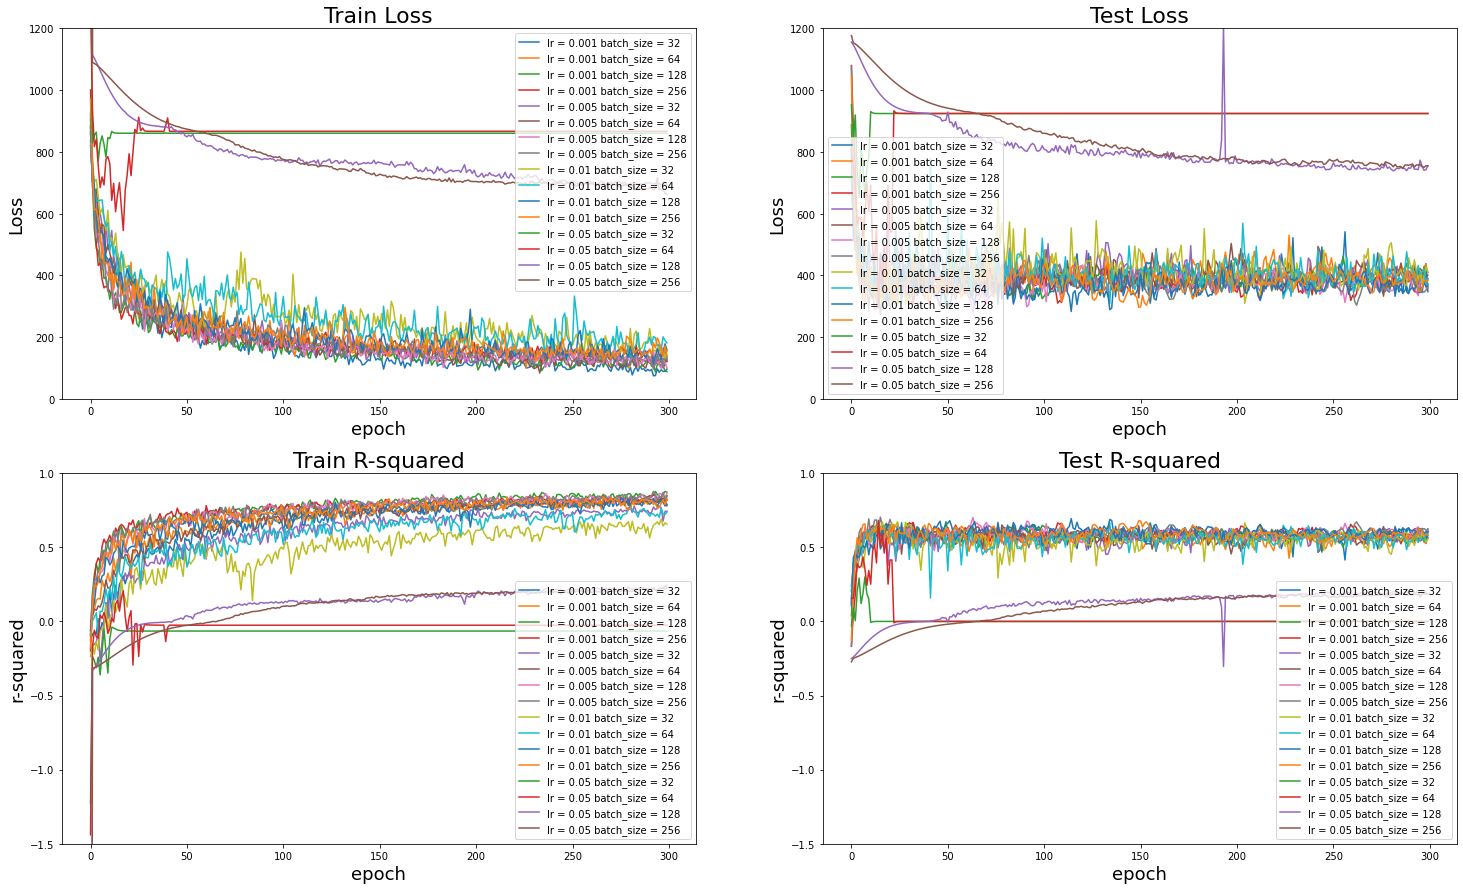

<Figure size 1800x1080 with 0 Axes>

In [13]:
def plot_all(ax, data_list):
    ax.plot(data_list[0],label="lr = 0.001 batch_size = 32")
    ax.plot(data_list[1],label="lr = 0.001 batch_size = 64")
    ax.plot(data_list[2],label="lr = 0.001 batch_size = 128")
    ax.plot(data_list[3],label="lr = 0.001 batch_size = 256")

    ax.plot(data_list[4],label="lr = 0.005 batch_size = 32")
    ax.plot(data_list[5],label="lr = 0.005 batch_size = 64")
    ax.plot(data_list[6],label="lr = 0.005 batch_size = 128")
    ax.plot(data_list[7],label="lr = 0.005 batch_size = 256")

    ax.plot(data_list[8],label="lr = 0.01 batch_size = 32")
    ax.plot(data_list[9],label="lr = 0.01 batch_size = 64")
    ax.plot(data_list[10],label="lr = 0.01 batch_size = 128")
    ax.plot(data_list[11],label="lr = 0.01 batch_size = 256")

    ax.plot(data_list[12],label="lr = 0.05 batch_size = 32")
    ax.plot(data_list[13],label="lr = 0.05 batch_size = 64")
    ax.plot(data_list[14],label="lr = 0.05 batch_size = 128")
    ax.plot(data_list[15],label="lr = 0.05 batch_size = 256")

figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure(figsize=(25,15))
ax1.set_title("Train Loss", fontsize=22)
plot_all(ax1, train_losses_all)
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("Loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 1200])

ax2.set_title("Test Loss", fontsize=22)
plot_all(ax2, test_losses_all)
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("Loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 1200])

ax3.set_title("Train R-squared", fontsize=22)
plot_all(ax3, train_accs_all)
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("r-squared", fontsize=18)
ax3.legend()
ax3.set_ylim([-1.5,1])

ax4.set_title("Test R-squared", fontsize=22)
plot_all(ax4, test_accs_all)
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("r-squared", fontsize=18)
ax4.legend()
ax4.set_ylim([-1.5,1])

plt.show()

In [26]:
for data in train_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in test_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in train_losses_all:
    print(data[-1])

print("___________________\n")

for data in test_losses_all:
    print(data[-1])   
    

0.701655625667611
0.6979345234689495
0.7682827421799071
0.7568118413162505
0.5322023401226066
0.6766185695078247
0.6670842938271305
0.7427896437832331
0.3858653002168745
0.5918783861927543
0.7043793575864876
0.7228118757310298
-0.06490232836607002
-0.025599924129800316
0.08118623672233864
0.15341714840855344
___________________

0.6714290834150789
0.6270943364013168
0.655191711024591
0.5909435727166295
0.4496346659066973
0.6115300917274625
0.6291990401707612
0.6323663723084814
0.6151042406849798
0.5686182876296662
0.6387914651037376
0.6076098911688937
-7.432546963603848e-05
-7.398080648557404e-05
0.11087107943096097
0.15330626319091767
___________________

135.4292579749962
180.73083442296738
163.17312202453613
197.26849517822265
201.79668233301732
192.18263283754007
232.81566467285157
195.31894226074218
328.98323608992933
251.35452857384314
213.70342674255372
222.1526306152344
860.5925477263215
866.9175978440505
804.0363662719726
734.0385040283203
___________________

303.735412597656

### 2 best models

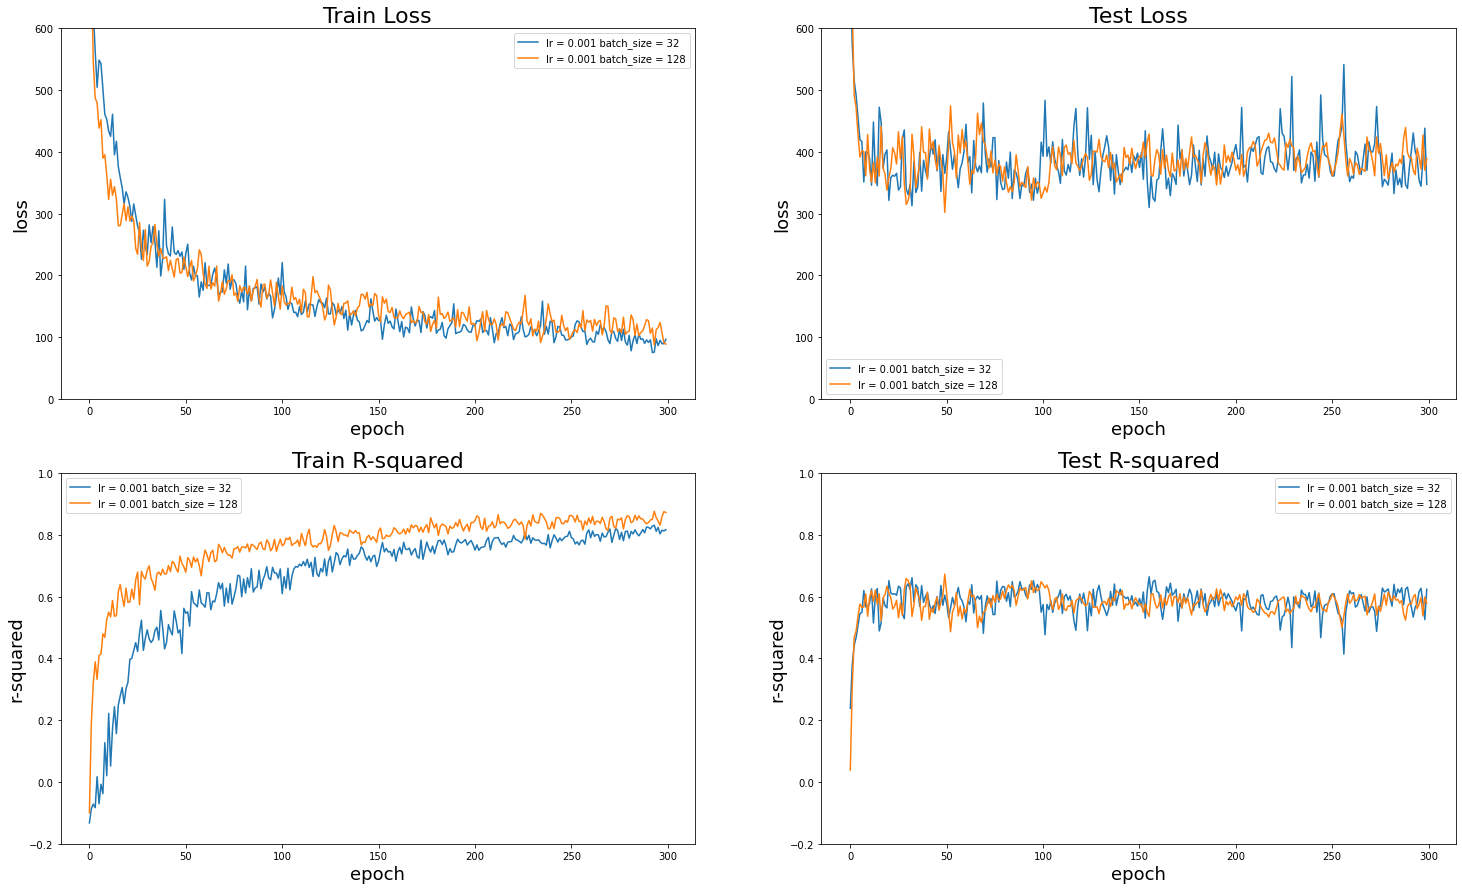

<Figure size 432x288 with 0 Axes>

In [15]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure()
ax1.set_title("Train Loss", fontsize=22)
ax1.plot(train_losses_all[0],label="lr = 0.001 batch_size = 32")
ax1.plot(train_losses_all[2],label="lr = 0.001 batch_size = 128")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 600])

ax2.set_title("Test Loss", fontsize=22)
ax2.plot(test_losses_all[0],label="lr = 0.001 batch_size = 32")
ax2.plot(test_losses_all[2],label="lr = 0.001 batch_size = 128")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 600])

ax3.set_title("Train R-squared", fontsize=22)
ax3.plot(train_accs_all[0],label="lr = 0.001 batch_size = 32")
ax3.plot(train_accs_all[2],label="lr = 0.001 batch_size = 128")
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("r-squared", fontsize=18)
ax3.legend()
ax3.set_ylim([-0.2,1])

ax4.set_title("Test R-squared", fontsize=22)
ax4.plot(test_accs_all[0],label="lr = 0.001 batch_size = 32")
ax4.plot(test_accs_all[2],label="lr = 0.001 batch_size = 128")
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("r-squared", fontsize=18)
ax4.legend()
ax4.set_ylim([-0.2,1])
plt.show()

## 4.2. Training

In [16]:
train_dataset = TensorDataset(torch.FloatTensor(X_train_all.values), torch.FloatTensor(y_train_all.values.reshape(-1, 1)))
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)

test_dataset = TensorDataset(torch.FloatTensor(X_test.values), torch.FloatTensor(y_test.values.reshape(-1, 1)))
test_loader = DataLoader(test_dataset, batch_size=704, shuffle=False)

In [17]:
model = FCNN()
model.cuda()

epochs = 300
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 0.001)

train_losses = []
test_losses = []
train_accs = []
test_accs = []

best_value = 1000
best_params = {'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
writer = SummaryWriter()

for epoch in range(1, epochs + 1):
    
    print('################## EPOCH {} ##################'.format(epoch))
    
    model.train()
    train_correct = 0
    train_loss = 0

    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())
            
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_acc = train_correct/len(train_loader)
    train_accs.append(train_acc)
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("R2/train", train_acc, epoch)
    print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))
    
    model.eval()
    
    test_loss = 0
    test_correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += criterion(output, target).item()
            test_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())
        
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_acc =test_correct/len(test_loader)
    test_accs.append(test_acc)

    if test_loss<best_value:
        best_value = test_loss
        torch.save(model.state_dict(), '../../models/caco_klek_fcnn_model.pt')
        best_params['epoch'] = epoch
        best_params['train_loss'] = train_loss
        best_params['test_loss'] = test_loss
        best_params['train_acc'] = train_acc
        best_params['test_acc'] = test_acc 
    writer.add_scalar("Loss/test", test_loss, epoch)
    writer.add_scalar("R2/test", test_acc, epoch)

    print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

writer.flush()
writer.close()

print(best_params)

################## EPOCH 1 ##################
Train Avg. loss: 908.4236394708806, Accuracy: -0.07963965058190073
Test Avg. loss: 1006.9966430664062, Accuracy: 0.02753498420268763
################## EPOCH 2 ##################
Train Avg. loss: 694.7889015891335, Accuracy: 0.19538688815488037
Test Avg. loss: 843.9130249023438, Accuracy: 0.18502614768377157
################## EPOCH 3 ##################
Train Avg. loss: 589.6756023060192, Accuracy: 0.2646481387000071
Test Avg. loss: 709.706787109375, Accuracy: 0.31463022332423995
################## EPOCH 4 ##################
Train Avg. loss: 516.1460210626775, Accuracy: 0.33889627058940536
Test Avg. loss: 609.1737670898438, Accuracy: 0.4117158160690527
################## EPOCH 5 ##################
Train Avg. loss: 463.9471581198952, Accuracy: 0.38489534615651116
Test Avg. loss: 668.90087890625, Accuracy: 0.35403683968564614
################## EPOCH 6 ##################
Train Avg. loss: 479.9341111616655, Accuracy: 0.3468099479097386
Test Av

Train Avg. loss: 242.6966192072088, Accuracy: 0.6738216350616423
Test Avg. loss: 562.9728393554688, Accuracy: 0.45633244531684913
################## EPOCH 50 ##################
Train Avg. loss: 230.6371244950728, Accuracy: 0.6968578380777486
Test Avg. loss: 513.6674194335938, Accuracy: 0.5039471165524174
################## EPOCH 51 ##################
Train Avg. loss: 204.50233667547053, Accuracy: 0.7114178524841512
Test Avg. loss: 513.8779296875, Accuracy: 0.5037438533755509
################## EPOCH 52 ##################
Train Avg. loss: 249.5166147405451, Accuracy: 0.6829199251341153
Test Avg. loss: 594.9205932617188, Accuracy: 0.4254802138081183
################## EPOCH 53 ##################
Train Avg. loss: 227.23455775867808, Accuracy: 0.6934592192614479
Test Avg. loss: 545.99853515625, Accuracy: 0.4727246927736377
################## EPOCH 54 ##################
Train Avg. loss: 217.93286999789152, Accuracy: 0.7113550616924407
Test Avg. loss: 560.4273681640625, Accuracy: 0.458790622

Train Avg. loss: 185.25107366388494, Accuracy: 0.7613532946747509
Test Avg. loss: 593.8187255859375, Accuracy: 0.4265443549503397
################## EPOCH 97 ##################
Train Avg. loss: 185.91284873268822, Accuracy: 0.7584057100719978
Test Avg. loss: 615.1068115234375, Accuracy: 0.4059862456995582
################## EPOCH 98 ##################
Train Avg. loss: 200.88373184204102, Accuracy: 0.7411476052789115
Test Avg. loss: 574.086669921875, Accuracy: 0.44559975639467453
################## EPOCH 99 ##################
Train Avg. loss: 182.86737580732867, Accuracy: 0.7452471023271297
Test Avg. loss: 574.2091064453125, Accuracy: 0.4454814690884724
################## EPOCH 100 ##################
Train Avg. loss: 189.94829247214577, Accuracy: 0.7337763570425418
Test Avg. loss: 628.8796997070312, Accuracy: 0.39268565629495766
################## EPOCH 101 ##################
Train Avg. loss: 163.10196755149147, Accuracy: 0.7672925444406477
Test Avg. loss: 557.1316528320312, Accuracy: 0

Train Avg. loss: 114.5884219082919, Accuracy: 0.8278074039882849
Test Avg. loss: 517.7938232421875, Accuracy: 0.4999621956515673
################## EPOCH 145 ##################
Train Avg. loss: 144.82738321477717, Accuracy: 0.8111195986149915
Test Avg. loss: 528.9918212890625, Accuracy: 0.48914816296605435
################## EPOCH 146 ##################
Train Avg. loss: 157.74292096224698, Accuracy: 0.7909481452890076
Test Avg. loss: 584.5524291992188, Accuracy: 0.4354928481014134
################## EPOCH 147 ##################
Train Avg. loss: 180.76701493696734, Accuracy: 0.7620317109671657
Test Avg. loss: 534.7677001953125, Accuracy: 0.48357035622688627
################## EPOCH 148 ##################
Train Avg. loss: 151.20017936012962, Accuracy: 0.7944657880387361
Test Avg. loss: 544.7791137695312, Accuracy: 0.47390224545046755
################## EPOCH 149 ##################
Train Avg. loss: 155.54570492831144, Accuracy: 0.7860449310838465
Test Avg. loss: 585.646240234375, Accuracy

Train Avg. loss: 145.3598879033869, Accuracy: 0.8042321890336211
Test Avg. loss: 536.3038330078125, Accuracy: 0.4820869099431122
################## EPOCH 193 ##################
Train Avg. loss: 135.56689418445933, Accuracy: 0.8157590176082952
Test Avg. loss: 540.6762084960938, Accuracy: 0.47786448219848854
################## EPOCH 194 ##################
Train Avg. loss: 133.95109662142667, Accuracy: 0.8118757156627165
Test Avg. loss: 546.171142578125, Accuracy: 0.4725580157788607
################## EPOCH 195 ##################
Train Avg. loss: 131.85619267550382, Accuracy: 0.8138154950902874
Test Avg. loss: 552.1085205078125, Accuracy: 0.4668241552500131
################## EPOCH 196 ##################
Train Avg. loss: 127.72162697531961, Accuracy: 0.8111342954854553
Test Avg. loss: 552.1981811523438, Accuracy: 0.46673763456837525
################## EPOCH 197 ##################
Train Avg. loss: 130.41932435469195, Accuracy: 0.8208398408125063
Test Avg. loss: 562.5007934570312, Accuracy:

Train Avg. loss: 182.75069080699575, Accuracy: 0.7693086213001075
Test Avg. loss: 549.4880981445312, Accuracy: 0.4693547393448405
################## EPOCH 240 ##################
Train Avg. loss: 131.54855780168012, Accuracy: 0.8311810473923843
Test Avg. loss: 571.51220703125, Accuracy: 0.4480858896777238
################## EPOCH 241 ##################
Train Avg. loss: 135.29219766096637, Accuracy: 0.8204064626508921
Test Avg. loss: 571.2081298828125, Accuracy: 0.448379582020506
################## EPOCH 242 ##################
Train Avg. loss: 134.71256810968572, Accuracy: 0.8227372455563785
Test Avg. loss: 539.5111083984375, Accuracy: 0.4789896606954097
################## EPOCH 243 ##################
Train Avg. loss: 121.05704619667746, Accuracy: 0.8389816233045181
Test Avg. loss: 534.7697143554688, Accuracy: 0.48356844439058067
################## EPOCH 244 ##################
Train Avg. loss: 155.3156646381725, Accuracy: 0.7955443604982352
Test Avg. loss: 508.56756591796875, Accuracy: 0

Train Avg. loss: 125.19732839410955, Accuracy: 0.8429869567637365
Test Avg. loss: 567.6854248046875, Accuracy: 0.4517814678722022
################## EPOCH 288 ##################
Train Avg. loss: 147.8434066772461, Accuracy: 0.8255846859289933
Test Avg. loss: 591.8814086914062, Accuracy: 0.42841521035631447
################## EPOCH 289 ##################
Train Avg. loss: 122.61939933083274, Accuracy: 0.8387225155511736
Test Avg. loss: 547.9280395507812, Accuracy: 0.47086135959194175
################## EPOCH 290 ##################
Train Avg. loss: 126.78268311240457, Accuracy: 0.8329677263926766
Test Avg. loss: 560.4451293945312, Accuracy: 0.45877350361783764
################## EPOCH 291 ##################
Train Avg. loss: 121.62779062444514, Accuracy: 0.8457130350478022
Test Avg. loss: 559.609130859375, Accuracy: 0.45958076195982767
################## EPOCH 292 ##################
Train Avg. loss: 116.14438715848055, Accuracy: 0.8443279070988748
Test Avg. loss: 563.9896240234375, Accurac

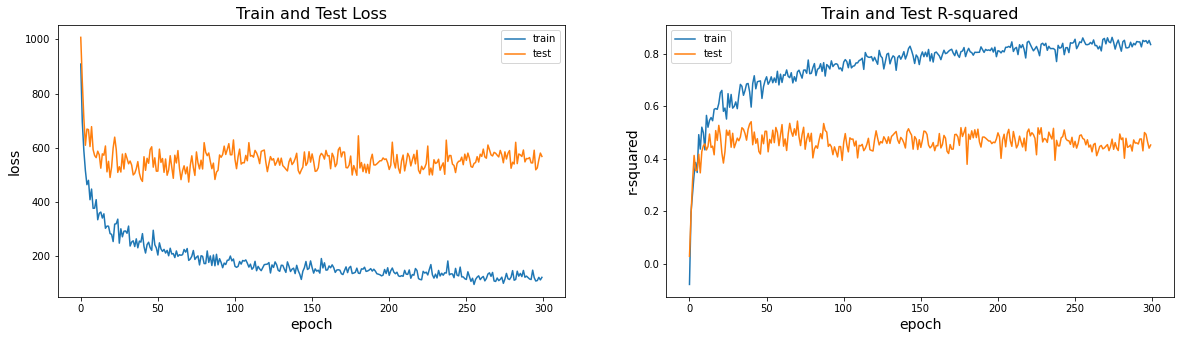

<Figure size 1440x360 with 0 Axes>

In [18]:
figure, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
plt.figure(figsize=(20,5))
ax1.set_title("Train and Test Loss", fontsize=16)
ax1.plot(train_losses,label="train")
ax1.plot(test_losses,label="test")
ax1.set_xlabel("epoch", fontsize=14)
ax1.set_ylabel("loss", fontsize=14)
ax1.legend()

ax2.set_title("Train and Test R-squared", fontsize=16)
ax2.plot(train_accs,label="train")
ax2.plot(test_accs,label="test")
ax2.set_xlabel("epoch", fontsize=14)
ax2.set_ylabel("r-squared", fontsize=14)
ax2.legend()
plt.show()

In [19]:
model = FCNN()
model.load_state_dict(torch.load('../../models/caco_klek_fcnn_model.pt'))
model.cuda()
model.eval()

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        output = model(data)
        predictons = output.cpu().detach().numpy()
        print_evaluate(target.cpu().detach().numpy(), predictons)

MAE: 10.167848
MSE: 473.54236
RMSE: 21.761028
R2 Square 0.5426961812400009 

